In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

In [2]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        coeff = 1 if model_fit.params[1] > 0 else -1
        return (model_fit.prsquared, coeff, model_fit)
    except np.linalg.LinAlgError:
        return (0, 0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        coeff = 1 if max(x[np.array(y, dtype=bool)]) == max(x) else -1 
        return (1, coeff, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [3]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output)

def get_trials(v1v2_values, starts_with_90):
    TRIAL_SAMPLE_SIZE = 300
    N_PFC_NEURONS = 500
    
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    match_trials = alevel_90_trials
    nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME

    # NOTE: Testing outcome period, not cue
#     cuetime_s = 150
#     cuetime_t = 200
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    betas = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): 
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, b_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, b_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
    
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        betas[neuron_idx,:] = [b_match, b_nonmatch]
        
    return (rsquareds, betas)

In [4]:
def save_obj(name, obj):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [5]:
# RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed127_MDon"]
# RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff"]

# RUNS_MD = ["seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10"]
# RUNS_MD_NO = ["seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10"]

# RUNS_MD = ["seed127_MDon", "seed88_MDon", "seed177_MDon_10", "seed83_MDon_10"]
# RUNS_MD_NO = ["seed127_MDoff", "seed88_MDoff", "seed177_MDoff_10", "seed83_MDon_10"]

# RUNS_MD = ["seed88_MDon"]
# RUNS_MD_NO = ["seed88_MDoff"]

# for i in range(len(RUNS_MD)):
#     data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")
#     data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD_NO[i] + "/by_trial")
#     save_obj(RUNS_MD[i], data_MDon)
#     save_obj(RUNS_MD_NO[i], data_MDoff)

In [6]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed88_MDon", "seed127_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10", "seed177_MDoff_10", "seed83_MDon_10"]


scores = []
scores_noMD = []
b = []
b_noMD = []

for i in range(len(RUNS_MD)):
    starts_with_90 = i < 5
    
    (rPFC_trials, task_input, v1v2_values, wPFC_output) = load_obj(RUNS_MD[i])
    (match_trials, nonmatch_trials, trials) = get_trials(v1v2_values, starts_with_90)
    (scores_, b_) = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)
        
    (rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD) = load_obj(RUNS_MD_NO[i])
    (match_trials_noMD, nonmatch_trials_noMD, trials_noMD) = get_trials(v1v2_values_noMD, starts_with_90)
    (scores_noMD_, b_noMD_) = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials_noMD, nonmatch_trials_noMD)
    
    if i == 0:
        scores = scores_
        scores_noMD = scores_noMD_
        b = b_
        b_noMD = b_noMD_
    else:
        scores = np.concatenate((scores, scores_), axis=0)
        b = np.concatenate((b, b_), axis=0)
        scores_noMD = np.concatenate((scores_noMD, scores_noMD_), axis=0)
        b_noMD = np.concatenate((b_noMD, b_noMD_), axis=0)

Optimization terminated successfully.
         Current function value: 0.071257
         Iterations 9
         Current function value: 0.104652
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.332570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.157823
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673075
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.591940
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.275157
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122621
         Iterations 11
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.045769
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.624362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.282951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153459
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.076177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148427
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014448
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.176312
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.02515

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114013
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086708
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.578220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.079255
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.657230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.549176
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054599
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135407
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.604184
         Iterations 7
         Current function value: 0.048884
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098979
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.215916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063967
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.184254
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122827
         Iterations 9
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.345398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.562821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.277381
         Iterations 7
         Current function value: 0.674640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.640730
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435894
         Iterations 8
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104588
         Iterations 9
         Current function value: 0.638989
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059602
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125627
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160009
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.199833
         Iterations 7
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446962
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031832
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.292814
         Iterations 7
         Current function value: 0.674640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528844
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.068755
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.117545
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048497
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157349
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.087513
         Iterations 16
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.239804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.262708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.646152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006847
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.617696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.295794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115013
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042351
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027316
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.431890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125369
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382416
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126889
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104805
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692751
         Iterations 4
         Current function value: 0.674640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684905
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083652
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.268876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019004
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.599242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025106
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029414
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.127821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.033865
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078818
         Iterations 10
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.123935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258733
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.233376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035601
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669893
         Iterations 6
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.335257
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.374630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.110380
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.159834
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027754
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.545634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688274
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.134319
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079300
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.503762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.089805
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.340429
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689904
         Iterations 5
         Current function value: 0.035270
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345682
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675394
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.275681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500182
         Iterations 7
         Current function value: 0.688437
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262659
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193776
         Iterations 8
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008028
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.124100
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.244816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017901
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.375331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065249
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.249202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166995
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099381
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089346
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.622094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055910
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.686113
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067817
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082494
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.404656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.441203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.0664

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.379697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.151254
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.271061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439698
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657593
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019598
         Iterations 11
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.327215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044696
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.337731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.539216
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182529
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112860
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071169
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049546
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.186222
         Iterations 8
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053284
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.148193
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014118
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.190385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073072
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.440039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690801
         Iterations 5
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.090465
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.059785
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.157870
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.544969
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124240
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016253
         Iterations 12
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060334
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.555862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017607
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.338842
         Iterations 7
         Current function value: 0.671774
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008088
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.633616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.114301
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.036500
         Iterations 11
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.136580
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.585101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.091510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.299313
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017032
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.664468
         Iterations 7
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.229438
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052794
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.353502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.532087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.251547
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019911
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.166826
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081047
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042106
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099500
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025576
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.156746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401290
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.169051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068954
         Iterations 9
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038518
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189244
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.271944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.230755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.152944
         Iterations 8
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.217247
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.126802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.208187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022016
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.255994
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118090
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.509822
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015567
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006170
         Iterations 17
         Current function value: 0.000018
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079313
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084950
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.208549
         Iterations 8
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.107891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065191
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298366
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.309608
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117638
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060904
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.119329
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052969
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.206885
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075719
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.155471
         Iterations 8
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.213304
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689773
         Iterations 6
         Current function value: 0.141285
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.083886
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049785
         Iterations 13
         Current function value: 0.674640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686648
         Iterations 7
         Current function value: 0.114308
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692728
         Iterations 4
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.326698
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.674640
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.088436
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.623714
         Iterations 35
Optimization terminated successfully.
         Current function value: 0.690705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683877
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.24037

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637616
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.502342
         Iterations 7
         Current function value: 0.141285
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157055
         Iterations 9
         Current function value: 0.674640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049225
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049158
         Iterations 19
         Current function value: 0.690385
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690787
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693011
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686231
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116983
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.494751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684012
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.612171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682325
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602505
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013453
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.482018
         Iterations 8
         Current function value: 0.686210
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.468079
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.681690
         Iterations 13
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.060935
         Iterations 10
         Current function value: 0.674640
         Iterations: 50
         Current function value: 0.690831
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673127
         Iterations 5
         Current function value: 0.683703
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346563
         Iterations 8
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.119896
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042429
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.642106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049367
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686210
         Iterations 35
Optimization terminated successfully.
         Current function value: 0.017874
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.547511
         Iterations 7
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062251
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.688168
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.333082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386063
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049192
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.106344
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.078223
         Iterations 10
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683703
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159860
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049265
         Iterations 15
         Current function value: 0.612067
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171564
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262128
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328124
         Iterations 7
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135239
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023925
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.026985
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.360022
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.232946
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369213
         Iterations 7
         Current function value: 0.678059
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.503265
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276426
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039161
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.238455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.216838
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.177628
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013524
         Iterations 13
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646309
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283353
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.116605
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.511131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.210192
         Iterations 9
         Current function value: 0.000189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556153
         Iterations 6
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118454
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.172692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678110
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.224787
         Iterations 9
         Current function value: 0.607109
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073430
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.648370
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281831
         Iterations 9
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257991
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126113
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033051
         Iterations 12
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.678059
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.638455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.007122
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.043799
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.223175
         Iterations 8
         Current function value: 0.659545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207602
         Iterations 8
         Current function value: 0.678059
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179841
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692430
         Iterations 3
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.222119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198526
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324486
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599655
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.687722
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688086
         Iterations 4
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681695
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.293796
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058931
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064971
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031827
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.280132
         Iterations 8
         Current function value: 0.036126
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465819
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.445230
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230652
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.125775
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.588519
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687592
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.490142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.153722
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.485924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663869
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040530
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.620115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411969
         Iterations 7
         Current function value: 0.000008
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069429
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009219
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013355
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322617
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261396
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.068748
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.541163
         Iterations 6
         Current function value: 0.680323
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039711
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051779
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022354
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.015816
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017523
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010507
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.647599
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.151717
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033370
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.600515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677966
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263239
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030666
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007644
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.668578
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006273
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.673841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015885
         Iterations 13
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.368993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030738
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148075
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.048421
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110666
         Iterations 9
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.625009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314739
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.074694
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.045832
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.600121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646963
         Iterations 5
         Current function value: inf
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180034
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054250
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.235325
         Iterations 8
         Current function value: 0.678059
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.311325
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036057
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014779
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.470229
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162089
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.505584
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673718
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145198
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224404
         Iterations 8
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336514
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.240826
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015860
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119359
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.612170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060847
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027416
         Iterations 12
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.668742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.043778
         Iterations 11
         Current function value: 0.640512
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157836
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059590
         Iterations 24
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219752
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.420110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216292
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.214291
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344077
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111474
         Iterations 9
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682132
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.427239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110909
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018125
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.034368
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.263432
         Iterations 12
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102747
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009890
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.021117
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.623276
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480260
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666736
         Iterations 6
         Current function value: 0.680095
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036249
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.189200
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187198
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.606655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469387
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080437
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227582
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.218639
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.284520
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011340
         Iterations 14
         Current function value: 0.680095
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032551
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.166945
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181569
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690591
         Iterations 9
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254630
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.645866
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690170
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043748
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.439787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.546616
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031943
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.199548
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.198697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.481777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.133381
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.263892
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.143545
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690337
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065450
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545472
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.126595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086550
         Iterations 11
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054369
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.225382
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153442
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.231747
         Iterations 9
         Current function value: 0.000000
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438402
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.061800
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.222994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.671101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.297465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.444221
         Iterations 7
         Current function value: 0.000000
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.685538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.109128
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.016554
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.440734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.584460
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029786
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024844
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.193815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063582
         Iterations 11
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.661438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680869
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.029391
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.596886
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.044175
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675681
         Iterations 9
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.518447
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019934
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648683
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425678
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367603
         Iterations 7
         Current function value: 0.000001
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135967
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.158108
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.075435
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.602521
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674961
         Iterations 7
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006738
         Iterations 16
         Current function value: 0.684255
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688137
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068468
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.679194
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353446
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206911
         Iterations 8
         Current function value: 0.680323
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180234
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.611357
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071803
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260752
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652805
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.364030
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.008729
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.427590
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.008563
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.096128
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: 0.204058
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680492
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.074210
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053522
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683882
         Iterations 6
         Current function value: 0.104665
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.362217
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.686141
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.602649
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.023173
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089591
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030529
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.686142
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.685077
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063014
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020363
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.079363
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.252105
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.040943
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683053
         Iterations 4
         Current function value: 0.626009
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679009
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691366
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.325359
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035001
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124046
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.669981
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073768
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565121
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094814
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027847
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075944
         Iterations 9
         Current function value: 0.197461
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674754
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061071
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030963
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503090
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567537
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256503
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.196753
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.616825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405782
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080071
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.160904
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595778
         Iterations 7
         Current function value: 0.000020
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.318733
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.628842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.294437
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046327
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.415746
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.367357
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395261
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086481
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.119966
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.111641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.247551
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.127800
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089796
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043702
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.052824
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017811
         Iterations 13
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689106
         Iterations 5
         Current function value: 0.650127
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260438
         Iterations 14
         Current function value: 0.034284
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082325
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044264
         Iterations 10
         Current function value: 0.000000
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038892
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.066749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.061528
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.155872
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.543358
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153009
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681260
         Iterations 36
Optimization terminated successfully.
         Current function value: 0.232966
         Iterations 7
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089843
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226006
         Iterations 8
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219853
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153994
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.660810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.122222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057381
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.044462
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.594824
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030044
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.490198
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061985
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028686
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285525
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691559
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.107923
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.166906
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404018
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072372
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020113
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.476538
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.511878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645394
         Iterations 5
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.293995
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417652
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077816
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055768
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064394
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684534
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.148507
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690246
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017465
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.049734
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.016515
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.056970
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.546490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156762
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.368126
         Iterations 7
         Current function value: 0.175851
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017762
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103621
         Iterations 9
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189911
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048615
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.072922
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.668200
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.613046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.302539
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028514
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013811
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.048085
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.068307
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030551
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.681651
         Iterations: 50
         Current function value: 0.087258
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066920
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.642688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.052194
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044153
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330839
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.429603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019056
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.576951


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120719
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052853
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.547745
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.171233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.413733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.500574
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.237355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019283
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362067
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365410
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225428
         Iterations 8
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083450
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.116890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023601
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.441696
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040365
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.017389
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060929
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047667
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024198
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060966
         Iterations 10
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088063
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086297
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024843
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120027
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329515
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328968
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.052697
         Iterations 9
         Current function value: 0.677407
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160426
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074570
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.326644
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.608395
         Iterations 6
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.275224
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047739
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097978
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.448686
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093140
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.453902
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.619895
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056967
         Iterations 10
         Current function value: 0.667711
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110685
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.342641
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.034562
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.256771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.116549
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.079193
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.357244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.132056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086818
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.018075
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173123
         Iterations 8
         Current function value: 0.574602
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119707
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.635794
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060576
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.448541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167398
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.096072
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.508674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.253877
         Iterations 8
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.480670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041358
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.619882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.200197
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296523
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130636
         Iterations 8
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.494138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049736
         Iterations 20
         Current function value: inf
         Iterations: 50
         Current function value: 0.000020
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061310
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.662034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691714
         Iterations 3
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.071410
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024623
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.262545
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.397965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688168
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.504475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.058367
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.035131
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046695
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046353
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009123
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.263220
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401354
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018985
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.008999
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.117630
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.187928
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.543415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.203974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190214
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000016
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.207441
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063069
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301935
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679699
         Iterations 5
         Current function value: 0.687430
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.075581
         Iterations 9
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.321087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.128250
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054900
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.657053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022303
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225399
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.175408
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.324880
         Iterations 8
         Current function value: 0.686318
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189014
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069101
         Iterations 11
         Current function value: 0.192559
         Iterations: 50
         Current function value: 0.000019
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499768
         Iterations 7
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000150
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691723
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.154692
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.115545
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.021745
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.129082
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.465268
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689327
         Iterations 6
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.382625
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227016
         Iterations 8
         Current function value: 0.675432
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053279
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082910
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685103
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.053122
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656954
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007885
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.689754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687276
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683641
         Iterations 4
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.108762
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133587
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.118077
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.597163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621924
         Iterations 26
         Current function value: 0.686713
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079503
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035135
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.113359
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.526573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.093630
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.189273
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.599223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687430
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.437853
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024115
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.133410
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.239982
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.089264
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077007
         Iterations 9
         Current function value: 0.340221
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189653
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063189
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076995
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.588902
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671952
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.055293
         Iterations 10
         Current function value: 0.020363
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064187
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297855
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113640
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.660216
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.090343
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024349
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.056076
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093206
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016579
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387810
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.641858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366926
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.690162
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155196
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034037
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.519608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057810
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.530227
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.047715
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690721
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 8.197338
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.102834
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041769
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241288
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.170798
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.200045
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013875
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017424
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011288
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.53

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045423
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039998
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.450702
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049543
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654766
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.273661
         Iterations 8
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.459943
         Iterations 7
         Current function value: 0.670621
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011041
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.685125
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078914
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005689
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.582153
         Iterations: 50
         Current function value: 0.474010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.392362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.136753
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.623097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032166
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.062463
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.030750
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.601813
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115875
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155766
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334105
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049754
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163019
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.197274
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079977
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.690162
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.434809
         Iterations 7
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692522
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202537
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.244302
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.176034
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688168
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136536
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051219
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.304980
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690446
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328815
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014592
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.574183
         Iterations 6
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000204
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.152253
         Iterations 9
         Current function value: 0.398056
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057835
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.220829
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.479657
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021562
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678285
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.379517
         Iterations 7
         Current function value: 0.618385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006152
         Iterations 16
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021253
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.648458
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032749
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.704478
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160372
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.120671
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120561
         Iterations 10
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669892
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027003
         Iterations 12
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.016898
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007396
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.166969
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098243
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.123043
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120339
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.183022
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008191
         Iterations 16
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.409319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022696
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689358
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.074284
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098768
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186236
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.102184
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079192
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020332
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020462
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349790
         Iterations 24
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635468
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.311001
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.340199
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075542
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.162222
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673875
         Iterations 5
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011104
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.677261
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.029097
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.511820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.274846
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032915
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.613185
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.586908
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.504331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030271
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.680906
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.653365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686542
         Iterations 4
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.282401
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019469
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.537688
         Iterations 6
         Current function value: 0.003980
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032914
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662482
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344492
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.032333
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016963
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202588
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.610992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566446
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.158970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.554141
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068242
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.316062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034476
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045153
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.231526
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024706
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191451
         Iterations 8
         Current function value: 0.657977
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021439
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019538
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011757
         Iterations 14
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009618
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053413
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098631
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131663
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006085
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.627747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.455254
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.035320
         Iterations: 50
         Current function value: 0.000085
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389472
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.270517
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.004915
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimiza

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005191
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.228316
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.146853
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010790
         Iterations 14
         Current function value: 0.000004
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137609
         Iterations 9
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006025
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089742
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.253888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682946
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.393029
         Iterations 7
         Current function value: 0.000000
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.122940
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.485079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016536
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.666661
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043590
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663248
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664086
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.616552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.271050
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039492
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.241830
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.074407
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059161
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383395
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.065380
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.445869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683430
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013430
         Iterations 13
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053731
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008633
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.307652
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.019934
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015730
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044178
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.670036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025836
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226454
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592382
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180398
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.288315
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.009187
         Iterations 16
         Current function value: 0.360749
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044456
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.362605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178042
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230793
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054455
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.032898
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110966
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.280659
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678828
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094968
         Iterations 10
         Current function value: 0.688168
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.089051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.274332
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144541
         Iterations 9
         Current function value: 0.685470
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217727
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.178689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212810
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669109
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110565
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.141363
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.020929
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.137091
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.644353
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684508
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.078112
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038077
         Iterations 11
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101796
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.198525
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110502
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152968
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015762
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.076925
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047206
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.675329
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014742
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.506938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.190431
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function value: 0.008743
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.121338
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068492
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.145074
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084433
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000022
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665335
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692294
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.248422
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.604327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025071
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.536011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.197976
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.393521
         Iterations 6
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.648695
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005444
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.031728
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.194916
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692990
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.157789
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.521981
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112486
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.336818
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.228014
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.448353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.248930
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296872
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.619993
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654773
         Iterations 5
         Current function value: 0.001018
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020078
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290120
         Iterations 9
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026240
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.642824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.295988
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062802
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.295370
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.558363
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688513
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.209367
         Iterations 22
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608685
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019935
         Iterations 22
         Current function value: 0.021462
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160623
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.513005
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.130230
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097389
         Iterations 11
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.064860
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.321660
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.019934
         Iterations 34
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182009
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045274
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.231732
         Iterations 8
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.115675
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.411450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690235
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.034365
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575742
         Iterations 6
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.599001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.246240
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.064159
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.447035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011929
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007349
         Iterations 18
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022405
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.083758
         Iterations 9
         Current function value: 0.019934
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.239074
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.087955
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283133
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.582008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101713
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.556739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420263
         Iterations 6
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.107428
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.186927
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.553216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.582068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.149738
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.429933
         Iterations 7
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170281
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.066376
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648695
         Iterations 39
Optimization terminated successfully.
         Current function value: 0.088669
         Iterations 9
         Current function value: 0.403932
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.206909
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029182
         Iterations 11
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.168181
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028011
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.152109
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.457234
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.053255
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.433942
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073538
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283836
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.183784
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136626
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416465
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062848
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.623905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361454
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.283199
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686618
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.191431
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047293
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211432
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067135
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.171811
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248527
         Iterations 8
         Current function value: 0.648695
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038147
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.648695
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137658
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.448436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326822
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025350
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.222402
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236331
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.648695
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.216898
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429825
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071272
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059182
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036728
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077448
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025711
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.171099
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.438210
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048752
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690623
         Iterations 9
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416196
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103485
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.199767
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090294
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028767
         Iterations 13
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649013
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211012
         Iterations 9
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.048870
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081920
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.554730
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130074
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019530
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422350
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514469
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315325
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028211
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.251518
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019937
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063114
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006275
         Iterations 33
Optimization terminated successfully.
         Current function value: 0.385210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027986
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039135
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686655
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201364
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.566138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.069940
         Iterations 11
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520153
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.156082
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088286
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.479433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.128566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040046
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687334
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.672400
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025075
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109770
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.492207
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.648695
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.587737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.227573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.484495
         Iterations 7
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020221
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107337
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648556
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.053913
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.397947
         Iterations 44
Optimization terminated successfully.
         Current function value: 0.035444
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.481788
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012705
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020502
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.083249
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.102432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043244
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020878
         Iterations 11
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.101325
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.111849
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030701
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188708
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.347919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021005
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.276884
         Iterations 7
         Current function value: 0.019934
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029443
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.121566
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688675
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051869
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067338
         Iterations 10
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.360709
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.100051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.234028
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.606810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.1635

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.082485
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005120
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.090828
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133235
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149660
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013184
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303624
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.307857
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.648695
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644450
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216527
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020195
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187314
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035648
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065157
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031644
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367665
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045230
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317747
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022371
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.059001
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.166599
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137643
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095204
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149993
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.471305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692881
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.551453
         Iterations 6
         Current function value: 0.035582
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.151689
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009158
         Iterations 16
         Current function value: 0.191431
         Iterations: 50
         Current function value: inf
         Iterations: 50
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.620300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689322
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.650695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026042
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.671419
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017499
         Iterations 13
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.566118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009457
         Iterations 14
         Current function value: 0.648695
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.236164
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027857
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.055258
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081681
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010162
         Iterations 12
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.195648
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011226
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.067060
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.286210
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300451
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164306
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.039090
         Iterations 10
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.683545
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.558677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.240257
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.285276
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482394
         Iterations 9
         Current function value: 0.690697
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.648695
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.499967
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.257574
         Iterations 8
         Current function value: 0.648695
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692212
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608364
         Iterations 7
         Current function value: 0.019666
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.025403
         Iterations 11
         Current function value: 0.000005
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.648695
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.648695
         Iterations: 50
         Current function value: 0.154463
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010762
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.008731
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690847
         Iterations 7
         Current function value: 0.062009
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.109063
         Iterations 10
         Current function value: 0.516951
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196723
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023311
         Iterations 20
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430480
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.153898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.352087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.16

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.489376
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027664
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.630585
         Iterations 6
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012864
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693056
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.467383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448219
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624141
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.019934
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370613
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.488098
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.231975
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029110
         Iterations 11
         Current function value: 0.713944
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205061
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.632389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409549
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.198834
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181069
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.020270
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.239947
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075862
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.599712
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420361
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.548952
         Iterations 6
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.549999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.245199
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.615888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687301
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015483
         Iterations 12
         Current function value: 0.690385
         Iterations: 50
         Current function value: 0.648695
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.393389
         Iterations 12
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030457
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.461778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361832
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.075243
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012209
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009118
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440834
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000124
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622148
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.562563
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056703
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.325879
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.526011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.226758
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056579
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057911
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.557406
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.229630
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158473
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.418920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.152132
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675704
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568228
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367697
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051747
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.683703
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006155
         Iterations 16
         Current function value: 1.369348
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.020069
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693019
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315724
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338586
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630589
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009755
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000012
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110577
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087187
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.535701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125608
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037135
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.039890
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018237
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.692036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.125163
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692531
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254390
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.068239
         Iterations 10
         Current function value: 0.624921
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179916
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444074
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.611126
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.522639
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056595
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.323630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.165183
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.279580
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217985
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063579
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031893
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148222
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033287
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022687
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277917
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.371407
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047264
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250799
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.480511
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018701
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.679284
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019058
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573901
         Iterations 6
Opti

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021463
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.499989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057917
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.368013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.301351
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188601
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.587196
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053192
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.045677
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.143815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.472666
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.170145
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691849
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.181798
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.223566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.496799
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215457
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.419286
         Iterations 7
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.654197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.039107
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449596
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.32141

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611024
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080481
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035395
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.087803
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.194466
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.586768
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.189237
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125259
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217684
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015557
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.166874
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682740
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033172
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017735
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.023905
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248528
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157328
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686625
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.416655
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030204
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016029
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319287
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246779
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.073737
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.008472
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.557892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.047511
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.464316
         Iterations 7
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043995
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014968
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.033471
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.277050
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147700
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669009
         Iterations 5

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102976
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.573065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300664
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000027
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017743
         Iterations 15
         Current function value: 0.0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009440
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.155538
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088502
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006675
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.669399
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013049
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690222
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.501395
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.011140
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.658473
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.018224
         Iterations 13
         Current function value: 0.626539
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199627
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.552106
         Iterations 6
         Current function value: 0.676446
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693111
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066720
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017999
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565544
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.666528
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011025
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.181988
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.210419
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353177
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561436
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000896
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544826
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685485
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328224
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.276558
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518560
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.275572
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.660475
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111784
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.494634
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.010490
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.015610
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.403081
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.386589
         Iterations 7
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193840
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620606
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.667453
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647706
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686886
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.324415
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.159119
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299402
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241238
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084903
         Iterations 38


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.078695
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.623126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.553180
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057660
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.510169
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641827
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 1.456514
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.568190
         Iterations: 50
         Current function value: 0.694113
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015013
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.373852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.131155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.105277
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227896
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415223
         Iterations 7
         Current function value: 0.681503
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.408103
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315113
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.229327
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.672218
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.170987
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000102
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.578961
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.150491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.161610
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.446883
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.269668
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045087
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.231216
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058892
         Iterations 43
Optimization terminated successfully.
         Current function value: 0.499132
         Iterations 6
         Current function value: 0.690657
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.252458
         Iterations 8
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.278596
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.677648
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509456
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.433673
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623882
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.619115
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.430746
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666186
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.440990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057576
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085741
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097715
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.569223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065984
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.640101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.462842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274903
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147421
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082539
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.145931
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.377515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198507
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008769
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.688310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.527031
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027852
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.140028
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.163664
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173005
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336446
         Iterations 7
         Current function value: 0.457340
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.170027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118038
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.309513
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326479
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690412
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054678
         Iterations 11
         Current function value: 1.752468
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.240679
         Iterations 7
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040088
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092223
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407899
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023954
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.612667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.066266
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018668
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023979
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019843
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.646283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024181
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.313437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.164665
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246951
         Iterations 10
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.182745
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.242382
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044288
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.378598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633139
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028326
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.235230
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.633663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.160237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.405958
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.682250
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027354
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011818
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.645591
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685695
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025488
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022979
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.513929
         Iterations 7
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021270
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.056281
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.218376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.234671
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331495
         Iterations 7
         Current function value: 0.019864
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050970
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.019770
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691713
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.448692
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.207982
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228258
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.650667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006609
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.308979
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.223547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162472
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.623023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.478820
         Iterations 6
         Current function value: 0.687430
         Iterations: 50
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.169348
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069866
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080166
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.519112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016268
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673153
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.028683
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.466610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.172497
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205797
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149599
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647377
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296650
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.368075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.117854
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.027856
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.645057
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690216
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076545
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.423549
         Iterations 8
         Current function value: 0.001451
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101003
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682956
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106100
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.636551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020541
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684138
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457973
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021115
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.513812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378708
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.023232
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.072352
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.321561
         Iterations 7
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081091
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025497
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683457
         Iterations 6
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424386
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461647
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.100208
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.327414
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045531
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.022975
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691553
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687578
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145251
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144689
         Iterations 15
         Current function value: 0.093480
         Iterations: 50
         Current function value: 0.020303
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673217
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655494
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.454078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005019
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.660894
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.662408
         Iterations 6
         Current function value: 0.686321
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023602
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.136018
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180168
         Iterations 9
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237819
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.616213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042932
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364528
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088314
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026166
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010624
         Iterations 14
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.157210
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036270
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660712
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687805
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335919
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037022
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.503154
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076313
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154183
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.590174
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.255914
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034838
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.652245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.107362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.050432
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072203
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.437010
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.604806
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.265877
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042671
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018128
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020205
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.143321
         Iterations 10
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228914
         Iterations 8
         Current function value: 0.000015
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017338
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.180556
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025266
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.485856
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262236
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005993
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.423909
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102394
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173239
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067598
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020367
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257372
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.654830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637362
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111376
         Iterations 9
Op

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.452965
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.075396
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.019864
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158048
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006456
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.395486
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.401634
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.541424
         Iterations 6
         Current function value: 0.018167
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329933
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013247
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660849
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080869
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.127636
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038570
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136615
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.143812
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563111
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022048
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.600741
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.632343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407451
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055492
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.082056
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.463006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681106
         Iterations 5
         Current function value: 13.336515
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145846
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.265657
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155774
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651891
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.247495
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041639
         Iterations 11
         Current function value: 0.612024
         Iterations: 50
         Current function value: inf
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.192714
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.655004
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.665141
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.037661
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.265079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206939
         Iterations 8
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.604404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689943
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.478917
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.358712
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681552
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252630
         Iterations 11
         Current function value: 0.021483
         Iterations: 50
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.201052
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.654872
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.170810
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.103619
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.148751
         Iterations 11
         Current function value: 0.048394
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059968
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690580
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.053934
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.626942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.122361
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051828
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.174622
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018301
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075837
         Iterations 10
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.242689
         Iterations 7
         Current function value: 0.144589
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035378
         Iterations 12
         Current function value: 0.667499
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691723
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030863
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067885
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.540626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.373798
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042145
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.134126
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.631231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074341
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691634
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649136
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.497572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081773
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.180364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027454
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.410911
         Iterations 7
         Current function value: 0.648006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203493
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.161638
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.398155
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.172398
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023285
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.603080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.022335
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.042088
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255633

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022574
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.683510
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597723
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689528
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647962
         Iterations 8
         Current function value: 0.687885
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.665811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025872
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.048968
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.310454
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194625
         Iterations 15
         Current function value: 0.000092
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691679
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.396879
         Iterations 10
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019972
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690738
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008888
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689944
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.372564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.383313
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134817
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691462
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683381
         Iterations 4
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529291
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310308
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152356
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.381388
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328040
         Iterations 7
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369304
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667918
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.649222
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021610
         Iterations 12
         Current function value: 0.687349
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189466
         Iterations 9
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020584
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.148449
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.266400
         Iterations 8
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063500
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355572
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.601490
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057222
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.363517
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.564659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094788
         Iterations 9
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071474
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.604167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013063
         Iterations 14
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208793
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114263
         Iterations 8
         Current function value: 0.011704
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064116
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095508
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.283052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137422
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.559370
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027976
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692476
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.152129
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007467
         Iterations 15
         Current function value: 0.001741
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155499
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209662
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121933
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.185024
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067855
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330991
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224007
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692778
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022284
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689797
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.636458
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579507
         Iterations 6
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040441
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044797
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.230305
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023028
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.614408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.152297
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018307
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055126
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.331686
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155844
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.248613
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.680088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592120
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081514
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.266442
         Iterations 8
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027955
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.037780
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.268426
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417979
         Iterations 6
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.515920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269063
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012408
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021498
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034170
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.148901
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.278923
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685887
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.237031
         Iterations 8
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.020091
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304251
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457741
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.364194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025002
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131119
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180203
         Iterations 9
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338474
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169240
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131130
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.609758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690831
         Iterations 42
Optimization terminated successfully.
         Current function value: 0.604294
         Iterations 6
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.653614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182930
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.120405
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.623518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.118891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.626270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125063
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040767
         Iterations 11
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.127475
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040273
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573121
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692573
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.424431
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692883
         Iterations 4
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099290
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.536610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020139
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.689600
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.386709
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024719
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.125828
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.419426
         Iterations 7
         Current function value: 0.688325
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150741
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013701
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.423955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.268573
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.269975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320215
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054957
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025730
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690247
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.159539
         Iterations 8
         Current function value: 0.567971
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010659
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665659
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552560
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438550
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467081
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045989
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.308903
         Iterations 8
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.035585
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670880
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006310
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.672828
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660177
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 1.145946
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006365
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.269102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024842
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.086893
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171603
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240865
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638718
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077677
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026733
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026394
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.218306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092934
         Iterations 12
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037440
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.498866
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051080
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.053876
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.145527
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.512754
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189772
         Iterations 8
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.644231
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146473
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053787
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065773
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.277097
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030338
         Iterations 12
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053618
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024827
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019821
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.291410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.158682
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.421346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484678
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.632656
         Iterations 5
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170177
         Iterations 10
         Current function value: 0.007348
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023770
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.518341
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177472
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449156
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.104003
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110329
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.674280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153594
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038258
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221990
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643599
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110904
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.434691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372473
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691037
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075283
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.001215
         Iterations: 50
         Current function value: 0.02

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.406153
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.553860
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.031912
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385333
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028263
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.086067
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093863
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.128738
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444389
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022047
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.640123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011269
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.091677
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.518842
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144783
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225824
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067528
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074573
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016029
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012793
         Iterations 14
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.657480
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676072
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.021248
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.678499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.292525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185372
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072385
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652630
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667983
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.624689
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022015
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.175317
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059377
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046841
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.166234
         Iterations 8
         Current function value: 0.095531
         Iterations: 50
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.299273
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031121
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.068423
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.573705
         Iterations 6
         Current function value: 0.690787
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390315
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074769
         Iterations 10
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.085389
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014641
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.544443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074779
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686214
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669583
         Iterations 8
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.174981
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.160228
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.317727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117128
         Iterations 10
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.287043
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680478
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124881
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345566
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.032739
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692984
         Iterations 4
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.665378
         Iterations 7
         Current function value: 0.244593
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217701
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.620836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.605754
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020092
         Iterations 16
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679543
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 1.329007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049024
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.154880
         Iterations 11
         Current function value: 0.563526
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456849
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551341
         Iterations 6
         Current function value: 0.674092
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.433282
         Iterations 7
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005931
         Iterations 18
         Current function value: 0.308618
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143338
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019995
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.162900
         Iterations 8
         Current function value: 0.671745
         Iterations: 50
         Current function value: 0.349161
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097980
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116086
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.303136
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.382156
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657431
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.661859
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025150
         Iterations 11
         Current function value: 0.735425
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200903
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.020491
         Iterations 14
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010484
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.088294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.370390
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.567863
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.477088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309314
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439631
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012122
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.635278
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679825
         Iterations 6
         Current function value: 0.150581
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109629
         Iterations 9
         Current function value: 0.635278
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.497935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.158333
         Iterations 9
         Current function value: 0.049087
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182883
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164038
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.343937
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.207961
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.478235
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.095083
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.650962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.194231
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.233386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021765
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.112224
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687108
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.360294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.260474
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693030
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.447354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661521
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014100
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286469
         Iterations 7
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302616
         Iterations 7
         Current function value: 0.635278
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.446638
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.500208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632015
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.277858
         Iterations 7
         Current function value: 0.635278
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427530
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015310
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.194223
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038692
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688135
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133901
         Iterations 8
         Current function value: 0.142075
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101764
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113437
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100744
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.540838
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200386
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.043381
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.605442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.313910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.282107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406834
         Iterations 6
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686746
         Iterations 5
         Current function value: 0.105191
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.516320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384651
         Iterations 7
         Current function value: 0.001886
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.635278
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019399
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.491767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.008706
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.099437
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055066
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.383486
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035015
         Iterations 12
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.617053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446604
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019851
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.142812
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685989
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627060
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690427
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043831
         Iterations 11
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650605
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.149081
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.435004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432535
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.211910
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048884
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040338
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233700
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072948
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.345605
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.531923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645004
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283563
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.667478
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.178625
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.567328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023353
         Iterations 14
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631750
         Iterations 6
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213972
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409225
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050810
         Iterations 13
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373725
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.602271
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010433
         Iterations 15
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.682464
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257412
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464620
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018531
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.687742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690355
         Iterations 5
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.551324
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370301
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.066499
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.132539
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692998
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.667426
         Iterations 5
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057537
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290586
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012989
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.067356
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.008515
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.168302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.635278
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.656757
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151489
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.400981
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051258
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.439496
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.085542
         Iterations: 50
         Current function value: 0.662640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039264
         Iterations 10
         Current function value: 0.158855
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117061
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059677
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116918
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031028
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.023995
         Iterations 12
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012404
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.596786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139257
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.621629
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070011
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687114
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045763
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018791
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.537631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.161705
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.587069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060281
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195423
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.297387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561556
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.665051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.577433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.290659
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519833
         Iterations 6
         Current function value: 0.656856
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577178
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155845
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.431786
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.149828
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.325460
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130732
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.128238
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.311167
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535933
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116243
         Iterations 10
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.128422
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.678674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.282780
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383622
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692695
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200833
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.287710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.557657
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635278
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.470560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627198
         Iterations 5
         Current function value: 0.664678
         Iterations: 50
         Current function value: 0.020177
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009340
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.632918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656595
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.664678
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376941
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033447
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.292294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075407
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068498
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.273012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682551
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093303
         Iterations 11
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.466039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.604142
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104155
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606289
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133174
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115209
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198245
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071116
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669167
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.180956
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675315
         Iterations 5
         Current function value: 0.664678
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035754
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335914
         Iterations 8
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027780
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.539976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018727
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053867
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.228628
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016506
         Iterations 15
         Current function value: 0.125955
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680832
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.252842
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035521
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.501743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395743
         Iterations 8
         Current function value: 0.035405
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635290
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.096322
         Iterations 18
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.513306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675571
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201344
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.566900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150089
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.346196
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.044890
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.267748
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669632
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006216
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.429486
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071670
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.225655
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.204790
         Iterations 8
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.144118
         Iterations 9
         Current function value: 0.635278
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.094214
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.248848
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043506
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.607793
         Iterations 7
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.259150
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.035754
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063435
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.664678
         Iterations 43
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050092
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.616306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692270
         Iterations 4
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370098
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692292
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.653895
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.458027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.270291
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.258964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274951
         Iterations 8
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667258
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.608276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.034124
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679429
         Iterations 5
         Current function value: 0.679961
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291531
         Iterations 9
         Current function value: inf
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018310
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.109416
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.594876
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.220560
         Iterations 9
         Current function value: 0.674924
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.020177
         Iterations: 50
         Current function value: 0.631685
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616311
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.664678
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.679707
         Iterations 5
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011772
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.538261
         Iterations 11
         Current function value: 0.531184
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.689894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006746
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.665135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.438978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634814
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.689894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679961
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016252
         Iterations 19
         Current function value: 0.679961
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050611
         Iterations 30
         Current function value: 0.677446
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.566463
         Iterations 8
         Current function value: 0.667258
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692209
         Iterations 3
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.035724
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.277722
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.688398
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690128
         Iterations 5
         Current function value: 2.247666
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543133
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.60716

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637922
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.467794
         Iterations 6
         Current function value: 0.689894
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143422
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.337142
         Iterations 9
         Current function value: 0.662084
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.664678
         Iterations 47
         Current function value: 0.624954
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.060857
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.664678
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.187948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684996
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.659136
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.611554
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652873
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.032547
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563624
         Iterations 6
         Current function value: 0.142072
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.572182
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.590489
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.562745
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664702
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.165411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.247417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.175618
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.128501
         Iterations 17
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.534613
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425810
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059271
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444370
         Iterations 7
         Current function value: 0.656008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595484
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585809
         Iterations 6
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.561524
         Iterations 6
         Current function value: 0.000073
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018469
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.381429
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677412
         Iterations 4
         Current function value: 0.681454
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.014725
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.157150
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.225296
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672888
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.358589
         Iterations 7
         Current function value: 0.686345
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176747
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027649
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040698
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042708
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676656
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.083281
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011291
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.148720
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461046
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110540
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047016
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.104111
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.558506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.039428
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.390459
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674425
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057110
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.428363
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.425925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.659591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.128906
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.048158
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087220
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692590
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669150
         Iterations 5
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016750
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.013026
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.174351
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008892
         Iterations 16
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024323
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.134721
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519687
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.168131
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208925
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049398
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.105062
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.094607
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395588
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.472737
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097683
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.017369
         Iterations 16
         Current function value: 0.685942
         Iterations: 50
         Current function value: 0.000029
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690390
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.513071
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692245
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159097
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040154
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.453681
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089214
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.025998
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012031
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.354091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.26

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.836398
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039411
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119983
         Iterations 9
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.428401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.417003
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059602
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.353191
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020011
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010732
         Iterations 15
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690126
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182848
         Iterations 9
         Current function value: 0.692592
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030556
         Iterations 10
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018118
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.506646
         Iterations 6
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043122
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042548
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.023622
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.194339
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.401594
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.165873
         Iterations: 50
         Current function value: 0.610786
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.175940
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.165655
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.372669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.540915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.076564
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110777
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032601
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.662446
         Iterations 6
         Current function value: 0.000009
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.482300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.320233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.452288
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429287
         Iterations 7
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.569199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.155888
         Iterations 9
         Current function value: 0.000982
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.183027
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.061727
         Iterations 11
         Current function value: 0.505823
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055404
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075728
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025484
         Iterations 11
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021781
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123780
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.238764
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.455938
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014153
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.174006
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.313355
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.479194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.055446
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091976
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067048
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.643490
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.534687
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054606
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081331
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.479043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014451
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.679194
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.459821
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.272936
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.653646
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268260
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178952
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158225
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018162
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.339964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.280848
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636147
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376292
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067942
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.606376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409245
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.643894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423440
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218255
         Iterations 8
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.476834
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310882
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.320240
         Iterations 8
         Current function value: 0.690385
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624195
         Iterations 7
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034200
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.062538
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.140494
         Iterations 9
         Current function value: 0.690385
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633251
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.451143
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431086
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.600586
         Iterations 6
         Current function value: 0.685941
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185855
         Iterations 9
         Current function value: 0.648917
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.612380
         Iterations 6
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649496
         Iterations 5
         Current function value: 0.114298
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.016959
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.521416
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418009
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692359
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683703
         Iterations 18
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284201
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023321
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047800
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000188
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199993
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018614
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.073345
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011860
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245866
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.495863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011836
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.321764
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.097552
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.185912
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029199
         Iterations 10
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.365909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224591
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074930
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.526543
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252775
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017994
         Iterations 12
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000137
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103610
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.162027
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.378257
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120161
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026673
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.277017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664475
         Iterations 5
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000012
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461501
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023500
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690385
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194134
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271637
         Iterations 8
         Current function value: 0.690385
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.036207
         Iterations 10
         Current function value: 0.194911


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214602
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.597319
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035995
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.008768
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.323404
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164342
         Iterations 9
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.363393
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.287919
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.417934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.276624
         Iterations 8
         Current function value: 0.684574
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126014
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.436293
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690141
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.266063
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.457325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231159
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 1.805263
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226307
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020159
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040825
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.471679
         Iterations 7
         Current function value: 0.131056
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033320
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.512867
         Iterations 7
         Current function value: 0.050033
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.534947
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076268
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650139
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.613861
         Iterations 5
         Current function value: 0.0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.616400
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.594908
         Iterations: 50
         Current function value: 0.690385
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454589
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.189269
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014014
         Iterations 13
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692592
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018001
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691184
         Iterations 4
         Current function value: 0.274125
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026966
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021470
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.019934
         Iterations: 50
         Current function value: 0.621935
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.324937
         Iterations 8
         Current function value: 0.651060
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502459
         Iterations 6
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.210077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.038023
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011837
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690208
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048010
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.108710
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185148
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.056845
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.109865
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.290434
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.511434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.042450
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081095
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152444
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686553
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175215
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.644846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.084604
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.155782
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.263980
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086182
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.199656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007865
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.690041
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390167
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042861
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077205
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016166
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.669065
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.113718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.505263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.250422
         Iterations 9
         Current function value: 0.000298
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181997
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.546931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038090
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.442523
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.155368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016503
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.297759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.404683
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688658
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120034
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.187578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670646
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.488774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.291217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323976
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.396986
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674984
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598774
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.244351
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687863
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027404
         Iterations 10
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.582654
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165645
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029201
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.148898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.041868
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.154086
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113405
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.097928
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049083
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186618
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.019794
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042572
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690421
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196665
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.078578
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689789
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.044535
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223463
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.078252
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.407589
         Iterations 7
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024925
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.552352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367239
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.192409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.313134
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075682
         Iterations 10
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.100325
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.127139
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.665335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071943
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.462251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.195538
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054139
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030563
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.180638
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088977
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085679
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041721
         Iterations 12
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043864
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.225803
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170729
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673962
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.057764
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298206
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125607
         Iterations 8
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.351956
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122658
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.408491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.665622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011405
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.041509
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.333154
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064250
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083352
         Iterations 10
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.287033
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114077
         Iterations 8
         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055236
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.232670
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.564974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030135
         Iterations 12
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552468
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016684
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.462786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.260553
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020772
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.539130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094854
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060660
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688762
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039110
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.663806
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034178
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020617
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124812
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.186888
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689138
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000285
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673683
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023162
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.581384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167405
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172841
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009965
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.015845
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.241148
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.305628
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031093
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019796
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068743
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.562981
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.227272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027434
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.072775
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022448
         Iterations 11
         Current function value: 0.668769
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020479
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.445580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.111614
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174987
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084069
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676475
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350664
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055178
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075075
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.040856
         Iterations 11
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070874
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.449234
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055550
         Iterations 10
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686797
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011099
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.503506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032245
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033954
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.171132
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022466
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.617867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029028
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082400
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.328072
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051453
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.266144
         Iterations 12
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035928
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.411023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.129785
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688947
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075990
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675129
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.033687
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.052097
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.602437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.164080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013589
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.011725
         Iterations 14
         Current function value: inf
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.163141
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190611
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066020
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039137
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.604529
         Iterations 6
Optimization terminated successfully.
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044123
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046307
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.484241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.273715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.402051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043419
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.249941
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127408
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005785
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.171567
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009266
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.067501
         Iterations 9
         Current function value: 0.048320
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389024
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062717
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.554322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086475
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094911
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139140
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060746
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121637
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125358
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.150321
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053736
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.189166
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.576492
         Iterations 7
         Current function value: 0.000025
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094983
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061377
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.048243
         Iterations 10
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.048150
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014164
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.092879
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074147
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036849
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643363
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675070
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039572
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.135548
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133045
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059687
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.048909
         Iterations 10
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196514
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.673963
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053018
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074923
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.674485
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291800
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.070488
         Iterations 11
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.205437
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.066608
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.141909
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.489867
         Iterations 8
         Current function value: inf
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307135
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.411986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036491
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.627410
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.229044
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023622
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451565
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690044
         Iterations 4
         Current function value: 0.689582
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683827
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077221
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684189
         Iterations 13
         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.086161
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153481
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045261
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.649504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.021457
         Iterations 11
         Current function value: 0.681577
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139941
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.343463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269429
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.145638
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.662090
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.675693
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166732
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.034527
         Iterations 10
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048341
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.335488
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.048214
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042572
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041110
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.546671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020809
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.094566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.267538
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019908
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.536064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689873
         Iterations 4
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.086941
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076176
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.235564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.007611
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677470
         Iterations 42
Optimization terminated successfully.
         Current function value: 0.096386
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.484666
         Iterations 15
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.630311
         Iterations: 50
         Current function value: 0.708201
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019794
         Iterations 33
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038907
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.368186
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.049609
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.684955
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083759
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.647379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014747
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279263
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000340
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306114
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.632929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259364
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010520
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584620
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.222544
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182501
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.032210
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007139
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.406654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015720
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.302592
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034221
         Iterations 12
         Current function value: 0.684953
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202791
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053552
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067266
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111827
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057249
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.207939
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050453
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201611
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.261460
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336120
         Iterations 7
         Current function value: 0.534422
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622880
         Iterations 5
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.025534
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.372674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683944
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209440
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.343842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.551227
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353771
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.424468
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101149
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009013
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.083066
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037080
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.640960
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089281
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030087
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.033452
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.202651
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585932
         Iterations 8
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123068
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053302
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.145411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283213
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057326
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.068321
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.193077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014855
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.092769
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.355169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037968
         Iterations 11
         Current function value: 0.686075
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023210
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.299847
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114050
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.639427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.218341
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030702
         Iterations 12
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046282
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048190
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213839
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119889
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335227
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102706
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116102
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022174
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.367259
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.187932
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037387
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.289258
         Iterations 8
         Current function value: 0.640043
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025573
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549869
         Iterations 6
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007562
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.197601
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263036
         Iterations 12
         Current function value: 0.684953
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.577278
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.569679
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.334737
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017357
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.180897
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.655913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.337117
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.549722
         Iterations 7
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.377005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.099891
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051011
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083950
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033080
         Iterations 12
         Current function value: 0.000139
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028881
         Iterations 12
         Current function value: inf
         Iterations: 50
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681318
         Iterations 23
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.180120
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.487187
         Iterations 6
         Current function value: 0.690787
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.440249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571045
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.670632
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652956
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131746
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.490352
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.601976
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.661508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.110425
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027635
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.016343
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.680950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476468
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.222900
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017780
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.101500
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118916
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027946
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008195
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037717
         Iterations 12
         Current function value: 0.690163
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016564
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.024593
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.020177
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180870
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678397
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.328131
         Iterations 8
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111624
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683545
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.033746
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079567
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675068
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259455
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.663312
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436583
         Iterations 7
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104825
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.623376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025995
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.032066
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014391
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.073183
         Iterations 11
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068029
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.576609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.496245
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680326
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010331
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667565
         Iterations 5
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.667677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.005531
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.381642
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.556422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.043307
         Iterations 11
         Current function value: 0.196108
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057624
         Iterations 11
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202451
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048935
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.034653
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.078084
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.478655
         Iterations 7
         Current function value: 0.690787
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615612
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115343
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169846
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.058598
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617493
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692380
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102322
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.109404
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689309
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293713
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.599899
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.605412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049799
         Iterations 11
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.540141
         Iterations 7
         Current function value: 0.667157
         Iterations: 50
         Current function value: 0.210286
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562993
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.683883
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072725
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005914
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.173034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119489
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.105160
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.568064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.073907
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480891
         Iterations 6
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.347665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005815
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.657652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637912
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144700
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201212
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.272801
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.123532
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.124063
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042115
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.632457
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021314
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.033761
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199254
         Iterations 8
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.688837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666375
         Iterations 6
         Current function value: 0.000209
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045393
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.597308
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405385
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000135
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.660630
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373157
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657947
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301659
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193251
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044687
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.241700
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226784
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.042330
         Iterations 12
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.675870
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044562
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024870
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581243
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.184367
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668331
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303394
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 1.571

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.690787
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021002
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.688527
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027988
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.558780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686075
         Iterations 26
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071317
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299783
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064777
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.189310
         Iterations 9
         Current function value: 0.670019
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071345
         Iterations 10
         Current function value: 0.688438
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073356
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.283774
         Iterations 9
         Current function value: 0.687430
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063041
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.183707
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.070363
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.417026
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081658
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.606790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051779
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.684953
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068286
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.100276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.361075
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010292
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.612094
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241985
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.277143
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.613276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015931
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.016318
         Iterations 13
         Current function value: 0.150864
         Iterations: 50
         Current function value: 0.690163
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674919
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.057569
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Opti

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.229101
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659049
         Iterations 7
         Current function value: 0.684953
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.020028
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086605
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073171
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.645125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.196233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.587623
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.089585
         Iterations 9
         Current function value: inf
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645322
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120224
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022103
         Iterations 12
         Current function value: 0.107874
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014555
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.105952
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029027
         Iterations 12
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.529774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018742
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.153278
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562677
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044614
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080644
         Iterations 9
         Current function value: 0.050104
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039037
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038355
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040344
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.129536
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.302145
         Iterations 9
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683484
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020343
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019697
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147653
         Iterations 8
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217872
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106070
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033801
         Iterations 11
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.069235
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018024
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.042314
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264365
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088334
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042074
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.198856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428151
         Iterations 7
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027148
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.078622
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032529
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011967
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.088265
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010844
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.335184
         Iterations 7
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065616
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679016
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102114
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067664
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095751
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.213998
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.091057
         Iterations 9

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686996
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088053
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200439
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.198524
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675784
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136063
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.086766
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044640
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676316
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182608
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048579
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.171061
         Iterations 8
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622181
         Iterations 6
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037345
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.554380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.120347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101699
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031752
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036637
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037228
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.266748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146390
         Iterations 10
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006787
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059420
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.289365
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012730
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040658
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.313293
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.585882
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.328244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.581228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.281474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034904
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.029769
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037907
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009203
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054667
         Iterations 10
         Current function value: inf
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114039
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.384888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.255732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.164879
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113716
         Iterations 10
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080726
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.599901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.075740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.100309
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098456
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.206178
         Iterations 9
         Current function value: inf
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035225
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.615498
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324466
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.530891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186304
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.298129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.250407
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.534063
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044775
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.376648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472430
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183693
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163818
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028238
         Iterations 13
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.204588
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262615
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063022
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.500311
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318717
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.448213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.114656
         Iterations 9
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.091430
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.139447
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.134034
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006158
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041826
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.038615
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.649936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.072976
         Iterations 11
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255932
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012036
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.237989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096236
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014165
         Iterations 16
         Current function value: 0.309655
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 39
Optimization terminated successfully.
         Current function value: 0.079375
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.036085
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085342
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.617279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317287
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099965
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.580905
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.275633
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.587638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092165
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131097
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071325
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110766
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.045401
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.566708
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000030
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.054405
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155863
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.128974
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.271220
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248823
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025326
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.644770
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.224102
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.449186
         Iterations 6
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692147
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646014
         Iterations 6
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.494471
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080014
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.170250
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035013
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.235712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140983
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146398
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.103383
         Iterations 9
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.357939
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.132973
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.058839
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103881
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.210090
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.039851
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.681035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364536
         Iterations 7
         Current function value: 0.672252
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576277
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204662
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.623921
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113840
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116470
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.131230
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.174011
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.121807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.606886
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.068293
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181202
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076173
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.658096
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034563
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054978
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.499865
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049184
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649026
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.255483
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095952
         Iterations 8
         Current function value: 0.518274
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364410
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691700
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129952
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.186550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044963
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120390
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008407
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.112272
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.530175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.203973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077156
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.377582
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.121262

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088893
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.568862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.117827
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640970
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232417
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.156351
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071211
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283143
         Iterations 8
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.312142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.119071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041612
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036394
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.150045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.218796
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206102
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.116414
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113704
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019095


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110773
         Iterations 11
         Current function value: 0.686142
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324144
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691992
         Iterations 3
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073198
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.298511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.172735
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.051608
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038947
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648853
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050482
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623105
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.582028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692335
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.079039
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.111779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.519293
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.550101
         Iterations 7
         Current function value: 0.000438
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031361
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.381614
         Iterations 10
         Current function value: 0.035224
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.112779
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117117
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531263
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037764
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.647630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.570074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603429
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031240
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.205511
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161717
         Iterations 8
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073606
         Iterations 14
         Current function value: 0.686142
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.524712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.502608
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.314508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.082462
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.208119
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435461
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671734
         Iterations 5
         Current function value: 0.072959
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102853
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.660360
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.595492
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541322
         Iterations 10
         Current function value: 0.533716
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692341
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.330100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656154
         Iterations 6
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038578
         Iterations 11
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033595
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619139
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.397540
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038353
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.639749
         Iterations 5
         Current function value: 0.688437
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059811
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.177128
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.495926
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.526481
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583000
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.571047
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.087477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.245433
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000007
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074418
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150204
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042946
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.353008
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055743
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086377
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.475256
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033544
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.551285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268999
         Iterations 8
         Current function value: 0.000000
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.031621
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683859
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672756
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056026
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046193
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.052387
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049722
         Iterations 11
         Current function value: 0.000000
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024757
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222704
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000092
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065914
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084455
         Iterations 9
         Current function value: 0.000000
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.155073
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621876
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017451
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010576
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.011297
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.228336
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035921
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059493
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047388
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020564
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.041636
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011820
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017927
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.169431
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.022181
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.117751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.165173
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412680
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085095
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.193411
         Iterations 9
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.557681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536125
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073473
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.571605
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000333
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084409
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.491354
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038052
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.560821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549205
         Iterations 6
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064568
         Iterations 11
         Current function value: 0.566333
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690283
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065424
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.283141
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072272
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689987
         Iterations 4
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.137432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.516007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668598
         Iterations 5
         Current function value: 0.000034
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.545064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.061167
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.045022
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103916
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.010780
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.080496
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.614343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.252338
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.553343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.100840
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046448
         Iterations 31
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.081043
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461888
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648420
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158320
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032326
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.156331
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.485604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305508
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031367
         Iterations 11
         Current function value: 0.565595
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039862
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.186325
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.650698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.016916
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685530
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.688437
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154931
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.075459
         Iterations 10
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.687491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.030425
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091839
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.621584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.091157
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.061193
         Iterations 12
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.289158
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.549483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639472
         Iterations 6
         Current function value: 0.674502
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538701
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.109401
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690312
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129559
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012498
         Iterations 13
         Current function value: 2.255095
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069099
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.104411
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.333399
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583068
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219373
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.651090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.267566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449653
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.524758
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417030
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060502
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.306069
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636764
         Iterations 5
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033063
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030376
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.553039
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032117
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.547423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.064583
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.387879
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.160854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180645
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.378143
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028600
         Iterations 11
         Current function value: 0.688526
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509353
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005812
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.138088
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.280551
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016833
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238691
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006547
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.678415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.180700
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.504203
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.039652
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663373
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483708
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092529
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.549473
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691482
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688437
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.557706
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013305
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.547429
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031373
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.580981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048370
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112893
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.424954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.223677
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089239
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097931
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139064
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079507
         Iterations 10
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685803
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690831
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011553
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012177
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636897
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020909
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.633535
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688221
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007645
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.014504
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.420182
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.661905
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.658282
         Iterations 8
         Current function value: 0.035538
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.124733
         Iterations 9
         Current function value: 0.688526
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658401
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.117192
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035628
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111046
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.372130
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173638
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.665754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.520654
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688437
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008676
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199385
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.172130
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.509626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017031
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.276288
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165742
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155760
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116360
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.572605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.659134
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682485
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691210
         Iterations 4
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199226
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.165426
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162499
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.550054
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000008
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.290212
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691463
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088884
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.421201
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494069
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438304
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131837
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061983
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.514454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.165103
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.6920

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.231930
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.020309
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.448072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.549189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.124369
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.295075
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686448
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543100
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686678
         Iterations 6
         Current function value: 0.653943
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606193
         Iterations 6
         Current function value: 0.084904
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193726
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114000
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187671
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.464180
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273562
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.083728
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031181
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.095202
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204705
         Iterations 9
         Current function value: 0.688920
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160262
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657305
         Iterations 7
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061572
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.416751
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688526
         Iterations 16
         Current function value: 0.685537
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134233
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.686210
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019636
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.561404
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675272
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.460853
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020381
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.278552
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089688
         Iterations 12
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069377
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.453432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.124569
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.495097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172894
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677816
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.241894
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.12895

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680788
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661819
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.651571
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056006
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.204466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.403071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256283
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.425561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.436031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668281
         Iterations 6
         Current function value: 0.375906
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217070
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212682
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.651571
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.360462
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.459418
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044352
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441656
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564614
         Iterations 6
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.238658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.121303
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065967
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053769
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.675385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392519
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.191263
         Iterations 7
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120238
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.197848
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.493647
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593848
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.661355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473803
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011833
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.678690
         Iterations 5
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.671385
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158407
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.339726
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.643251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.094656
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.584936
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.241619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216130
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195386
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.113123
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.188992
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.191731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.156313
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.665003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015163
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.011001
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040965
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.044721
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.064449
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.092971
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690455
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.598565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.244403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.04747

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.419550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151126
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.366640
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688594
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415479
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.144642
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024893
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678354
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.044155
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.669674
         Iterations 6
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298171
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.180622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.525017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.186723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020304
         Iterations 12
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396876
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.267060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.511122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.065303
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019936
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.061571
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.192217
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.156474

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.282812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365192
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179939
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.672409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.475180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.222067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.612746
         Iterations 5
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019629
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.435801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.040472
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.511741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215587
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.206783
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.307214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053645
         Iterations 11
         Current function value: 0.049923
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.141032
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652115
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.212185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638770
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.325640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.309013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654266
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.131174
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.461391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.235042
         Iterations 9
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.308014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.282211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.276960
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222944
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.622952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649053
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011921
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.009417
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.294113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388701
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.247101
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.088412
         Iterations 10
         Current function value: 0.083280
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.623779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.273534
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.614670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.106910
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133440
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.222708
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687608
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345496
         Iterations 7
         Current function value: 0.175451
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.278261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651571
         Iterations 37
Optimization terminated successfully.
         Current function value: 0.351152
         Iterations 9
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117245
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.655604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.196576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181466
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148386
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.272536
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071524
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.635745
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.169421
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187978
         Iterations 9
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.104170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.340376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300130
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.527658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.292763
         Iterations 7
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.458139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645828
         Iterations 5
         Current function value: 0.651571
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.622183
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.511519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182860
         Iterations 8
         Current function value: inf
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 1.204296
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.252722
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.171247
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.038126
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.418965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025723
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.618710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623519
         Iterations 5
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038865
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.620220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.304570
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352170
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.242228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.128985
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.143696
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651804
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.096555
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.258084
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144375
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673948
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.266828
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133162
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025512
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.651571
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.670431
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.495952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.227153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413908
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.636334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.255400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686072
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.025975
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691083
         Iterations 4
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689998
         Iterations 4
         Current function value: 0.062350
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651568
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.583002
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.171457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126725
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552007
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.086161
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594397
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610329
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.565504
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265684
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227728
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350056
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.166471
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113770
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.478143
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641960
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094698
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134860
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.256242
         Iterations 7
         Current function value: 0.074272
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117737
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086176
         Iterations 18
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647821
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.194078
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.654220
         Iterations 32
Optimization terminated successfully.
         Current function value: 0.282027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688368
         Iterations 5
         Current function value: 1.349216
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642105
         Iterations 6
         Current function value: 0.136287
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.133837
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094015
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.406781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677374
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.674833
         Iterations: 50
         Current function value: 0.654220
         Iterations: 50
         Current function value: 0.363996
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532942
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265968
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681544
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674058
         Iterations 4
         Current function value: 0.177434
         Iterations: 50
         Current function value: 0.672220


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085638
         Iterations 16
         Current function value: 0.661501
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110706
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.447570
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.671439
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.690120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.032112
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.560272
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688546
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128770
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690414
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.262562
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.178514
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690454
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.499216
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.651571
         Iterations: 50
         Current function value: 0.629938
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.685301
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610423
         Iterations 6
         Current function value: 0.651571
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683960
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005434
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.68852

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.187311
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121333
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102037
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.646818
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.336426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224924
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.517717
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117335
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153316
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087584
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193672
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048148
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024961
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058023
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.548172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542806
         Iterations 6
         Current function value: 0.020160
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194678
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009663
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.038850
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.021921
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452082
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200003
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028572
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.400212
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014236
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016347
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.103478
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.534349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.158358
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692906
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.031528
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.048540
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.355824
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171828
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.509853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006521
         Iterations 23
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030174
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488497
         Iterations 6
         Current function value: 17.777873
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.085661
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039279
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.324864
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.643689
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.039461
         Iterations 12
         Current function value: inf
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580203
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.376593
         Iterations: 50
         Current function value: 0.000101
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041764
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.128322
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040214
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039376
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.225609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051650
         Iterations 11
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009551
         Iterations 13
         Current function value: 0.000029
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.497303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.252470
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.137016
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029805
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006051
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.132511
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069141
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.670279
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.692766
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247255
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.170712
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.178993
         Iterations 9
Optimization terminated successfully.
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.463701
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.461019
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.506299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081682
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009878
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026448
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.092410
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436736
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.022606
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.029936
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.594928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093748
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.269693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230671
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244364
         Iterations 9
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.374227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012023
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.027475
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024979
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.481390
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170820
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.235155
         Iterations 8
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.017647
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.211986
         Iterations 9
         Current function value: 0.685761
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006433
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.596472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021123
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.045047
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.537027
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653336
         Iterations 29
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035237
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048518
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.286808
         Iterations 8
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.415078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432143
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265736
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.612163
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.607874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674661
         Iterations 7
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029271
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.660670
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.686212
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018919
         Iterations 13
         Current function value: 0.025101
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000032
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018959
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.112119
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136219
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.199793
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073330
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028751
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022560
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.013752
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.124552
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.603643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689703
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.627053
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.511306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007598
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.433930
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657865
         Iterations 14
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139018
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019777
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173203
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019841
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214176
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.125493
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008849
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.077645
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.356762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.255884
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102862
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.644057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232609
         Iterations 8
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174776
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024943
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.468929
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350039
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.147012
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.484452
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154579
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042498
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255012
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198065
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020618
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691226
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656586
         Iterations 8
         Current function value: 0.604278
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.001041
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.326199
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.358588
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.354741
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.552941
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151214
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.549166
         Iterations 6
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200779
         Iterations 17
Optimiz

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.033648
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238260
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.448284
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037371
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034286
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.641801
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642754
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385641
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.138506
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012550
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.024640
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.524036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559647
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.666044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635842
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.091064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081089
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426694
         Iterations 18
         Current function value: 0.676778
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228290
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353160
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009956
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016312
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.243103
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009232
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046388
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.209809
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045366
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010245
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267919
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026039
         Iterations 12
         Current function value: 0.108968
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280348
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040991
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190302
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670025
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.610745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.095533
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158106
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.282036
         Iterations 8
         Current function value: 0.062100
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252598
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.090616
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.002818
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.632391
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272837
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651971
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.366311
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673544
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.606516
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088934
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.181155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676055
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.430201
         Iterations: 50
         Current function value: 0.512223
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027651
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365837
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.435481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.514087
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.176384
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.267371
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340213
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062790
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.341233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007603
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011056
         Iterations 14
         Current function value: 0.584504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189879
         Iterations 8
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000019
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115331
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.360198
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009019
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132096
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.676012
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043918
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013561
         Iterations 12
         Current function value: inf
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 1.087603
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678752
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.064415
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.186626
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691909
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464833
         Iterations 7
         Current function value: 0.676285
         Iterations: 50
         Current function value: 0.134572
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.445610
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.166910
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.491219
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.147916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182608
         Iterations 8
         Current function value: 0.003433
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320613
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.021950
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.662850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.244863
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.289891
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.494337
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.598065
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112619
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.135748
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.513278
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.308983
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192815
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092320
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.207352
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106694
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.027970
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.497714
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.108841
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077506
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092829
         Iterations 9
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026317
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047484
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013965
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.572544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078299
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.098347
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568280
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109784
         

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066120
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.208845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.246789
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.305426
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.095178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321494
         Iterations 7
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.590370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.141483
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.161122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.562049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095655
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.518111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.305749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027322
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.625111


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.665966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024092
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.246298
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.361397
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012949
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.147082
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.333741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004854


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.157559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419984
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019151
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.372780
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.262880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017129
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236866
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.085854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.176752
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.186933
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.502034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061754
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041889
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.304257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680548
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.528553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.132560
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.604551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.174564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007948
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.071109
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.044106
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.564160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064684
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.041619
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.452456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.174708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.541276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010142
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.415221


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019061
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.085490
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.241007
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.049104
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664371
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.103185
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.432849


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689913
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043252
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084474
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.274436
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.529217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.595544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017617
         Iterations 12
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.627785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.280174
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248348
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.637680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.061262
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.206663
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.626840
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.638420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.056708
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027958
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.406186
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.448804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.093558
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.050252
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017483

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058795
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.589391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692420
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.644159
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190828
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.570115
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006671
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.632329
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.091801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.145898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.643690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.201047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076084
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012407
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.364190

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690259
         Iterations 4
         Current function value: 0.685941
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342275
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.226624
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359840
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.253425
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118701
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.219778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186689
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033420
         Iterations 12
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022739
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.314077
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.641533
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179924
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156138
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190608
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.604391
         Iterations 8
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070765
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.214626
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.136358
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.280505
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.150633
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078171
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.162357
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.106345

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014176
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686947
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310212
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.584768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.083648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.465991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.519141
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264241
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.212712
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009307
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.671090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.035041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679975
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093702
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120996
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.549651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332352
         Iterations 8
         Current function value: 0.687721
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.128502
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.664653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669132
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.657739
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.226827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.643984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.601877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677657
         Iterations 35
Optimization terminated successfully.
         Current function value: 0.496451
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.074889

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.045236
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341472
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.058852
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.674951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.565385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.613297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.568853
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392176

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.152384
         Iterations 10
         Current function value: 0.669517
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030802
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.226465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.527657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.252243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.122246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411124
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.189317
         Iterations 9
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688168
         Iterations: 50
         Current function value: 0.107371
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052446
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046412
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592150
         Iterations 7
         Current function value: 0.035711
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203736
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.672815
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.634365
         Iterations 7
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068794
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.662191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.062172
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061053
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.123834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.620857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055857
         Iterations 25
         Current function value: 0.687721
         Iterations: 50
         Current function value: 0.393886
         Iterations: 50
         Current function value: 0.035711
         Iterations: 50
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.144846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.150834
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.178245
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.154081
         Iterations 13
         Current function value: 0.129843
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660698
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016877
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123934
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.441633
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092158
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.228113
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015765
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.456655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050195
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.366256
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066093
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.423376
         Iterations 7
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.248062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579276
         Iterations 7
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197708
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662731
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.044486
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.596330
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236263
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.348744
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022012
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.383757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038064
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.153045
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020189
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.049020
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.044511
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.010952
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.502819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030743
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.436082
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310598
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090095
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064292
         Iterations 11
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.563727
         Iterations 7
         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015901
         Iterations 13
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.668078
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048634
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.172863
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255492
         Iterations 9
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.136946
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.454512
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.165514
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.097921
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017091
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.138636
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169442
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038194
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.531266
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021870
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.121535
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020200
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.029238
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.044742
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.206990
         Iterations 23
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012507
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043326
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: 0.305688
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281487
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210686
         Iterations 8
         Current function value: 93.467040
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683433
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043648
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.616336
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225131
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175183
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086824
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.096373
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425871
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028130
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.684698
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031631
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.098650
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029122
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276206
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 23
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.268446
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016137
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.627650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690165
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.107318
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.602480
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031375
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.163159
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.028501
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016850
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.453838
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051562
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.551501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532492
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094114
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.290125
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611214
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.459804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020905
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.109122
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517378
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021122
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116788
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692339
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150211
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033236
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.595086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307972
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010750
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.161364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.449944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437830
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.474546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411267
         Iterations 8
         Current function value: 8.089506
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.505574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014198
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017952
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.652493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692121
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052702
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.129876
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174832
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035275
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.276238
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.020618
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.250809
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070695
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432520
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.497500
         Iterations 6
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.161812
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015436
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.624563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071665
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.621707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.296603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066919
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041540
         Iterations 11
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016331
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.182064
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.574370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.185434
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.154618
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044289
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.189623
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.302257
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.497386
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256548
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020745
         Iterations 13
         Current function value: 0.690565
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.474736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690672
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189282
         Iterations 9
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032369
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.601842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244740
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017783
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.515988
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.685540
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.635368
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036268
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011820
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.046031
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025864
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.625541
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029808
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.660455
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.161205
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010168
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027387
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.408898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.517172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006803
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127327
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029022
         Iterations 13
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037461
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.588718
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451912
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.336927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685290
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684647
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016318
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.491845
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691983
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.272278
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050462
         Iterations 12
         Current function value: 0.869828
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020174
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.597820
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082966
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118371
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013785
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.436989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.551827
         Iterations 6
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.057808
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030416
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196988
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.422328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.042463
         Iterations 11
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.238962
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043631
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242122
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027160
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.633322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353644
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208175
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226412
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126017
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407763
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173650
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.148622
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040645
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.676569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008558
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.215285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038688
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690639
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007658
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.630256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027684
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.150215
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040434
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.399138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.310617
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.190965
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.292992
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683817
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.424668
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096112
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019836
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015752

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472449
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107344
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084126
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.650607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.090262
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116378
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052296
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384225
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052490
         Iterations 11
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020253
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.064810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.503217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.194135
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016192
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.385505
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046508
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.678271
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.397728
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688957
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446147
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686522
         Iterations 7
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.628747
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380543
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007510
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.014937
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683958
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592680
         Iterations 6
Opti

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.203476
         Iterations 9
         Current function value: 0.019979
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017567
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691070
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.687430
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102688
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.094437
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.476503
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691823
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009584
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.401373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.196225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.646370
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187797
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.014482
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.556411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.223332
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.242127
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230863
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.140544
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044251
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.576890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372069
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.364598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.651918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692347
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001519
         Iterations: 50
         Current function value: 0.688439
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226344
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109528
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.107050
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.621355
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692131
         Iterations 4
         Current function value: 0.671064
         Iterations: 50
         Current function value: 0.083974
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.069734
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435279
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018780
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675320
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.327064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.600828
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457173
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.163787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.140229
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.122873
         Iterations 10
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.414373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006649
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.410553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.077637
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.401908
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.130132
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040129
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.141757
         Iterations 9
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.386362
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076473
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.205539
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084485
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.113957
         Iterations 9
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410133
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.066677
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091167
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.596863
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674833
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.012940
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.090382
         Iterations 9
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.433209
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019181
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.630935
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674833
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.078193
         Iterations 10
         Current function value: 0.674833
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430468
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.468541
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.225017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.084451
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.381535
         Iterations 7
         Current function value: 0.020282
         Iterations: 50
         Current function value: 0.000000
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.097484
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017386
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.452961
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.167096
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.440773
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.674833
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173236
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160428
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.300562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.039077
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157050
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131018
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.343537
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046555
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.278944
         Iterations 7
         Current function value: 0.674833
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066739
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.142723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047414
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.681919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.044988
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176585
         Iterations 8
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.247187
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152742
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031150
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.409997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022798
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021021
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.210077
         Iterations 7
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008716
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.678981
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.124885
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.008016
         Iterations 18
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193357
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238973
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.512151
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.053850
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675323
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.167762
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.074836
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006625
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.374971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438339
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.586279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.035449
         Iterations 11
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.478976
         Iterations 7
         Current function value: 0.186621
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346917
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.098998
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.492152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.265275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487684
         Iterations 8
         Current function value: 0.675455
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324633
         Iterations 8
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.222606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489392
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.127709
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.507303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.611400
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.065005
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.480336
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.489140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050054
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.018720
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.246355
         Iterations 7
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197284
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331860
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287676
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.492534
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.686713
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.296273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005619
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.013958
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075772
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.297852
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689907
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.336455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047846
         Iterations 15
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022009
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.302071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689969
         Iterations 4
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.176422
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.134367
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075480
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679630
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.188150
         Iterations 9
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168104
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130423
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026374
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.453530
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036098
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.635559
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130504
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.274604
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213171
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179681
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.222577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110709
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652177
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064453
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166184
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217037
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.332052
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.168868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255319
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199894
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.096709
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.494622
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.179539
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.626839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030147
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.070202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.158735
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673501
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.478165
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361133
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086811
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.341483
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133500
         Iterations 9
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.086161
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015115
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171692
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028419
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040931
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.213886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.275602
         Iterations 8
         Current function value: 0.086161
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092805
         Iterations 11
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.327482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670905
         Iterations 6
         Current function value: 0.020261
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036331
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.072071
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.129808
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032983
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051960
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.497369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.110414
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047061
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.496399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.154693
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.105348
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112685
         Iterations 11
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.086161
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255725
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.016792
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.012598
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.111968
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667869
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039234
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111546
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023386
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649960
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285661
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540052
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134266
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163366
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.634454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432369
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172818
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.086039
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038364
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026220
         Iterations 12
         Current function value: 0.096853
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416013
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033507
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.041627
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037591
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012998
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211986
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.259145
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.079141
         Iterations 10
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124633
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209392
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.667528
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284964
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.409767
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.038626
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.227818
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028245
         Iterations 12
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.255095
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125988
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033951
         Iterations 13
         Current function value: 0.662179
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022541
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.196434
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139880
         Iterations 9
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039646
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.247850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150130
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171772
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688456
         Iterations 5
         Current function value: 0.674833
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650483
         Iterations 6
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.086161
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.205569
         Iterations 9
         Current function value: 0.107209
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053238
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.313828
         Iterations 10
         Current function value: 0.656793
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676368
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594422
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.674833
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355916
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154385
         Iterations 9
         Current function value: 0.674833
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.209914
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.176817
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.101031
         Iterations 9
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.678063
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.580221
         Iterations 6
         Current function value: 0.153847
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202521
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170287
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.614909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680342
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.152659
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612694
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683543
         Iterations 5
         Current function value: 0.107209
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103015
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.608237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447035
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688470
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318419
         Iterations 8
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024105
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.426701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086508
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.148707
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.654099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.154795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.073929
         Iterations 12
         Current function value: 0.688379
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663297
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.039724
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.199899
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132672
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.687885
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.654049
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117325
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.253462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075020
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.667663
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.406321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.681002
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.563188
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.141158
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.563598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.625937
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687885
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.565824
         Iterations: 50
         Current function value: 0.683244
         Iterations: 50
         Current function value: 0.295966
         Iterations: 50
         Current function value: 0.664861
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690863
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.672143
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041434
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.290419
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.062642
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.553192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602687
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimizat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.406776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.280634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.066324
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.200469
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.195517
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110048
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.085964


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.516820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.219362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203843
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105473
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.101791
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.319675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.277151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093637
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.123636
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.119380
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.375776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.266041
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021674
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.532698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.173328
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684149
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225552
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552893
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013237
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.280677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.270141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.594512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103276
         Iterations 12
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037983
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.669214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058652
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.548318
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.170091
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.514597
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456568
         Iterations 7
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.167025
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.172943
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353243
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163227
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066935
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.291497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673588
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.069784
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041526
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165575
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.299091
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.143200
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196034
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190963
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105133
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.226176
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.036323
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.481475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021487
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.036425
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.208885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.292589
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147654
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068009
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098130
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185205
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.294245
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567460
         Iterations 14
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.555100
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.039795
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.536262
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.582752
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628514
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.623165
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037800
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629387
         Iterations 5
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.222368
         Iterations 8
         Current function value: 0.658536
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143123
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.583005
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.200072
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.221155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.244329
         Iterations 12
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.530269
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.554477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687991
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.295977
         Iterations 7
         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191224
         Iterations 8
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267172
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.477600
         Iterations 7
         Current function value: 0.909430
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027860
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.023106
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041563
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.409059
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579926
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264193
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.566301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572038
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322512
         Iterations 8
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329240
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038930
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.681235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.322845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226361
         Iterations 7
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.220144
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.254033
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.092600
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.048296
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.677901
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606343
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030928
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.489040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024078
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.607026
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162679
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272083
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019091
         Iterations 12
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209544
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226062
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.247981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.127692
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.638434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005299
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.058438
         Iterations 11
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004689
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.299972
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071175
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166904
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.269649
         Iterations 9
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.279903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018393
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.518438
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046767
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.509721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669074
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.554318

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068798
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.403977
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142954
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150038
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.048308
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.675006
         Iterations 9
         Current function value: 0.227120
         Iterations: 50
         Current function value: 0.103554
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175777
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055287
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.219329
         Iterations 7
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.182518
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073990
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.464864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.110579
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.050709
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.458302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.163698
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.181536
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113575
         Iterations 11
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214011
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006923
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.013118
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153096
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.472401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674278
         Iterations 5
         Current function value: 0.000018
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095773
         Iterations 10
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.399106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.624493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.235361
         Iterations 7
         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130003
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.171693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.650892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.260299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110061
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.110964
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.119833
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.180163
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.201152
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068358
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015772
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.199377
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.042532
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034223
         Iterations 11
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227466
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301666
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.316235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008664
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.670124
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041850
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000067
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.661453
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350810
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.489292
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023542
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.286726
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054661
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.113151
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.311915
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124870
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064846
         Iterations 11
         Current function value: 0.658536
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013174
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.234606
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034744
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.209049
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.023585
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.245504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209630
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690373
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.276771
         Iterations 8
         Current function value: 0.661453
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173271
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103554
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.103398
         Iterations 10
         Current function value: 0.098238
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021337
         Iterations 12
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.673544
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369766
         Iterations 15
         Current function value: 1.239827
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142236
         Iterations 9
         Current function value: 0.673544
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452223
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137931
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.666072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.125530
         Iterations 10
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300839
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616084
         Iterations 12
         Current function value: 0.103554
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104247
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.418368
         Iterations 7
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.606193
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687846
         Iterations 4
         Current function value: 0.108787
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124470
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.581478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460737
         Iterations 7
         Current function value: 0.642106
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035814
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617000
         Iterations 6
         Current function value: 0.506967
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688206
         Iterations 5
         Current function value: 0.678628
         Iterations: 50
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.379281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.103973
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.150235
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.644673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065444
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.673544
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.661631
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005852
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092687
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.305087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140487
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.401916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 3.270986

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.675803
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620785
         Iterations 6
         Current function value: 0.648732
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683332
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036118
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.348217
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.049884
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.595020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.588924
         Iterations 6
         Current function value: inf
         Iterations: 50


In [18]:
def plot_bars(ax, D, style="number"):
    w = 0.3
    x = np.arange(len(D.keys()))
            
    means1 = []
    means2 = []
    std_errs1 = []
    std_errs2 = []
    
    d1s = []
    d2s = []
    for key in D:
        if style == "number":
            d1 = D[key][0]
            d2 = D[key][1]
        elif style == "perc-pfc":
            d1 = [x / N_PFC_NEURONS for x in D[key][0]]
            d2 = [x / N_PFC_NEURONS for x in D[key][1]]
        elif style == "perc-cue":
            d1 = []
            d2 = []
            for i in range(len(D[key][0])):
                x1 = D[key][0][i] / np.sum([D[k][0][i] for k in D.keys()])
                d1.append(x1)
                x2 = D[key][1][i] / np.sum([D[k][1][i] for k in D.keys()])
                d2.append(x2)
                
        means1.append(np.mean(d1))
        means2.append(np.mean(d2))
        std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
        std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
        d1s.append(d1)
        d2s.append(d2)

    ax.bar(x-w/2, means1, width=w, label="max")
    ax.errorbar(x-w/2, means1, std_errs1, color="k", capsize=2, zorder=20)
    ax.bar(x+w/2, means2, width=w, label="second max")
    ax.errorbar(x+w/2, means2, std_errs2, color="k", capsize=2, zorder=20)
    for i in range(len(d1s)):
        ax.scatter(np.ones(len(d1s[i]))*i-w/2, d1s[i], color="grey", marker="x", s=10, zorder=10)
        ax.scatter(np.ones(len(d2s[i]))*i+w/2, d2s[i], color="grey", marker="x", s=10, zorder=10)
    plt.xticks(x, D.keys(), rotation = 25)
    if style == "perc-pfc" or style == "perc-cue":
        ax.yaxis.set_major_formatter(PercentFormatter(1))



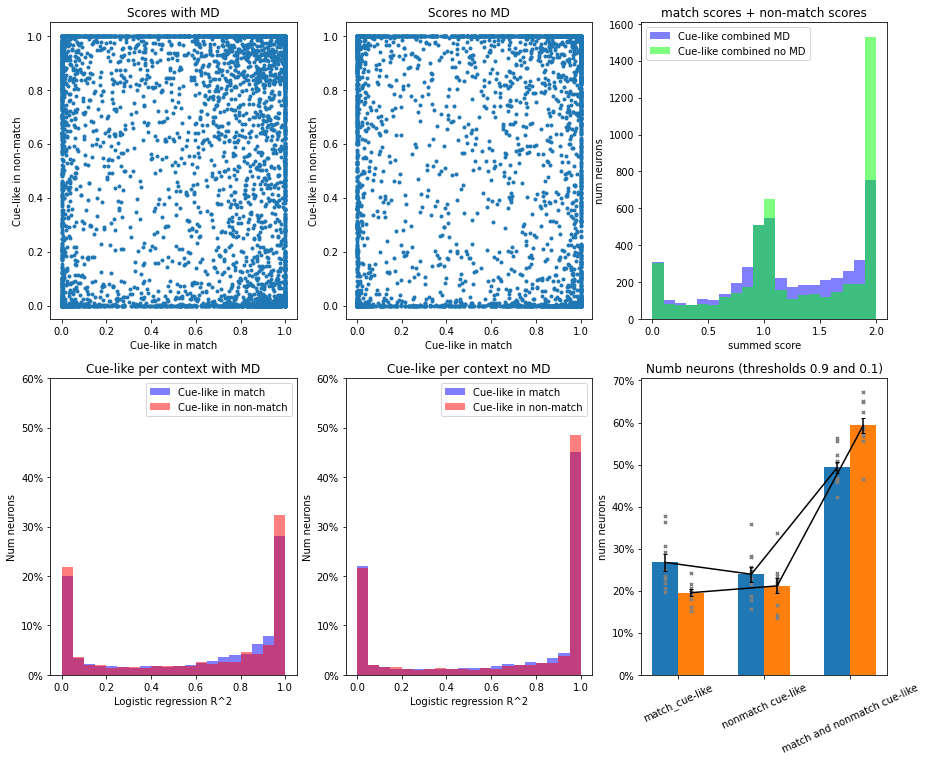

In [19]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))
N_PFC_NEURONS = 500
hist_weights = np.ones(N_PFC_NEURONS * len(RUNS_MD)) / (N_PFC_NEURONS * len(RUNS_MD))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(scores[:,0],scores[:,1], marker=".")
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax2.legend()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,0.6))

ax3 = fig.add_subplot(2,3,2)
ax3.scatter(scores_noMD[:,0],scores_noMD[:,1], marker=".")
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
w1 = np.ones(len(scores_noMD[:,0])) / len(scores_noMD[:,0])
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax4.legend()
ax4.yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,0.6))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)

def get_nums(s):
    num_cue1 = []
    num_cue2 = []
    num_cue = []
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        num_cue1.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]))
        num_cue2.append(len(np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]))
        num_cue.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]))
    return (num_cue1, num_cue2, num_cue)

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(ax6, D, "perc-cue")
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")
plt.show()


Text(0.5, 1.0, 'Num neurons (thresholds 0.9 and 0.1)')

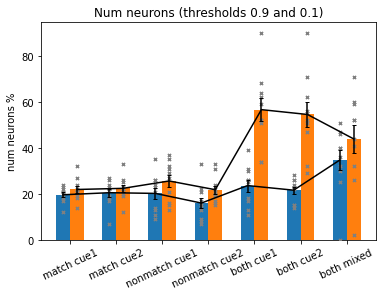

In [23]:
N_PFC_NEURONS = 500
def get_nums7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]

        match_cue1_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == 1)[0]]))
        match_cue2_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == -1)[0]]))
        nomatch_cue1_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]))
        nonmatch_cue2_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]))
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.append(len(cuelike_cue1_neurons_))
        cuelike_cue2_neurons.append(len(cuelike_cue2_neurons_))        
        cuelike_mixed_neurons.append(len(np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))))
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons)
                                     
                        
(num_match_cue1_neurons, num_match_cue2_neurons, num_nomatch_cue1_neurons, num_nonmatch_cue2_neurons, num_cuelike_cue1_neurons, num_cuelike_cue2_neurons, num_cuelike_mixed_neurons) = get_nums7(scores, b)
(num_match_cue1_neurons_noMD, num_match_cue2_neurons_noMD, num_nomatch_cue1_neurons_noMD, num_nonmatch_cue2_neurons_noMD, num_cuelike_cue1_neurons_noMD, num_cuelike_cue2_neurons_noMD, num_cuelike_mixed_neurons_noMD) = get_nums7(scores_noMD, b_noMD)
D = {}
D["match cue1"] = (num_match_cue1_neurons, num_match_cue1_neurons_noMD)
D["match cue2"] = (num_match_cue2_neurons, num_match_cue2_neurons_noMD)
D["nonmatch cue1"] = (num_nomatch_cue1_neurons, num_nomatch_cue1_neurons_noMD)
D["nonmatch cue2"] = (num_nonmatch_cue2_neurons, num_nonmatch_cue2_neurons_noMD)
D["both cue1"] = (num_cuelike_cue1_neurons, num_cuelike_cue1_neurons_noMD)
D["both cue2"] = (num_cuelike_cue2_neurons, num_cuelike_cue2_neurons_noMD)
D["both mixed"] = (num_cuelike_mixed_neurons, num_cuelike_mixed_neurons_noMD)                       
plot_bars(plt.gca(), D, "number")
plt.ylabel("num neurons %")
plt.title("Num neurons (thresholds 0.9 and 0.1)")
                                     

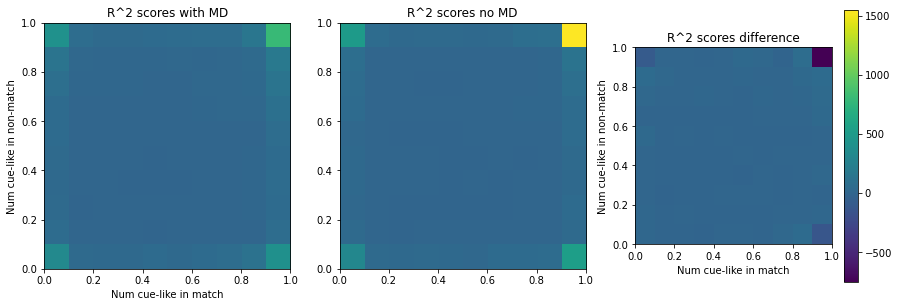

In [24]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

In [25]:
N_PFC_NEURONS = 500

def get_idxs7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]
        
        match_cue1_neurons.extend([match_neurons[np.where(b[match_neurons,0] == 1)[0]]])
        match_cue2_neurons.extend([match_neurons[np.where(b[match_neurons,0] == -1)[0]]])
        nomatch_cue1_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]])
        nonmatch_cue2_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]])
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.extend([cuelike_cue1_neurons_])
        cuelike_cue2_neurons.extend([cuelike_cue2_neurons_])     
        cuelike_mixed_neurons.extend([np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))])
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) 

(match_cue1_neurons, match_cue2_neurons, nonmatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) = get_idxs7(scores, b)
(match_cue1_neurons_noMD, match_cue2_neurons_noMD, nonmatch_cue1_neurons_noMD, nonmatch_cue2_neurons_noMD, cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD, cuelike_mixed_neurons_noMD) = get_idxs7(scores_noMD, b_noMD)


(3000, 2)
(4000, 72)


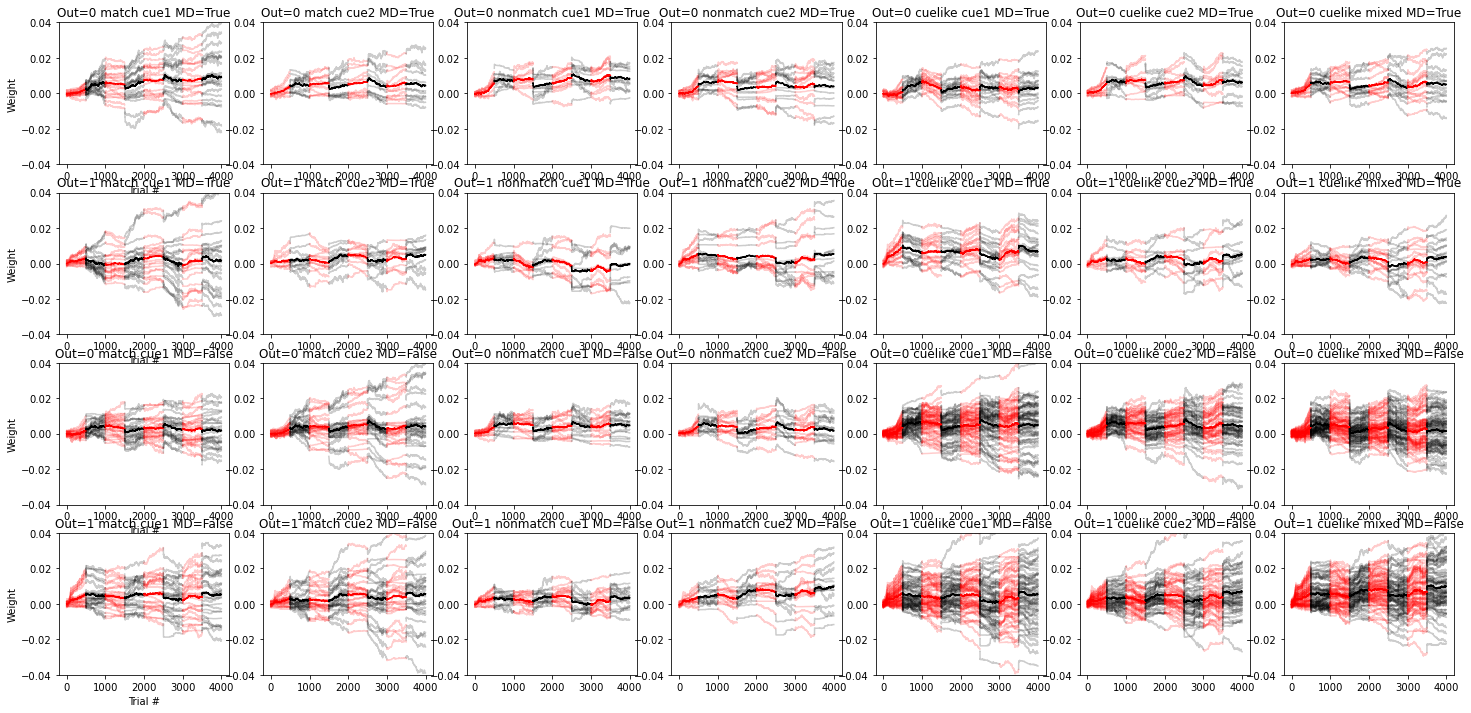

In [13]:
# IGNORE THIS CELL -- I FORGET WHAT'S GOING ON HERE

def plot_weights(run_idx, scores, wPFC_output, scores_noMD, wPFC_output_noMD):
    cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
    cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
    cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
    cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
    cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
    cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

    x = np.arange(0,4000)
    wPFC_out0_all = wPFC_output[match_trials,0,:]
    wPFC_out1_all = wPFC_output[match_trials,1,:]
    wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
    wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

    m0 = np.mean(wPFC_out0_all,1)
    m1 = np.mean(wPFC_out1_all,1)
    e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
    e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

    m0_noMD = np.mean(wPFC_out0_all_noMD,1)
    m1_noMD = np.mean(wPFC_out1_all_noMD,1)
    e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
    e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

    wPFC_out0_match_cue1_MD = wPFC_output[:,0,match_cue1_neurons[run_idx]]
    wPFC_out0_match_cue2_MD = wPFC_output[:,0,match_cue2_neurons[run_idx]]
    wPFC_out0_nonmatch_cue1_MD = wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]]
    wPFC_out0_nonmatch_cue2_MD = wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_cue1_MD = wPFC_output[:,0,cuelike_cue1_neurons[run_idx]]
    wPFC_out0_cuelike_cue2_MD = wPFC_output[:,0,cuelike_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_mixed_MD = wPFC_output[:,0,cuelike_mixed_neurons[run_idx]]

    wPFC_out1_match_cue1_MD = wPFC_output[:,1,match_cue1_neurons[run_idx]]
    wPFC_out1_match_cue2_MD = wPFC_output[:,1,match_cue2_neurons[run_idx]]
    wPFC_out1_nonmatch_cue1_MD = wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]]
    wPFC_out1_nonmatch_cue2_MD = wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_cue1_MD = wPFC_output[:,1,cuelike_cue1_neurons[run_idx]]
    wPFC_out1_cuelike_cue2_MD = wPFC_output[:,1,cuelike_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_mixed_MD = wPFC_output[:,1,cuelike_mixed_neurons[run_idx]]

    wPFC_out0_match_cue1_noMD = wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]]
    wPFC_out0_match_cue2_noMD = wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue1_noMD = wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue2_noMD = wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue1_noMD = wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue2_noMD = wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_mixed_noMD = wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]]

    wPFC_out1_match_cue1_noMD = wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]]
    wPFC_out1_match_cue2_noMD = wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue1_noMD = wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue2_noMD = wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue1_noMD = wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue2_noMD = wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_mixed_noMD = wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]]

    def plt_trials(ax, w):
        if w.shape[1] == 0:
            return

        match_blocks = [1,3,5,7]
        nmatch_blocks = [0,2,4,6]

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            m = np.mean(w[s:t,:],1)
            e = np.std(w[s:t,:],1)        
            ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
#             ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)

    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    plt_trials(ax1,wPFC_out0_match_cue1_MD)
    ax1.set_ylim((-0.04,0.04))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    plt_trials(ax2,wPFC_out0_match_cue2_MD)
    ax2.set_ylim((-0.04,0.04))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)
    ax3.set_ylim((-0.04,0.04))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)
    ax4.set_ylim((-0.04,0.04))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)
    ax5.set_ylim((-0.04,0.04))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)
    ax6.set_ylim((-0.04,0.04))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)
    ax7.set_ylim((-0.04,0.04))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    plt_trials(ax8,wPFC_out1_match_cue1_MD)
    ax8.set_ylim((-0.04,0.04))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    plt_trials(ax9,wPFC_out1_match_cue2_MD)
    ax9.set_ylim((-0.04,0.04))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)
    ax10.set_ylim((-0.04,0.04))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)
    ax11.set_ylim((-0.04,0.04))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)
    ax12.set_ylim((-0.04,0.04))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)
    ax13.set_ylim((-0.04,0.04))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)
    ax14.set_ylim((-0.04,0.04))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    plt_trials(ax15,wPFC_out0_match_cue1_noMD)
    ax15.set_ylim((-0.04,0.04))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    plt_trials(ax16,wPFC_out0_match_cue2_noMD)
    ax16.set_ylim((-0.04,0.04))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)
    ax17.set_ylim((-0.04,0.04))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)
    ax18.set_ylim((-0.04,0.04))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)
    ax19.set_ylim((-0.04,0.04))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)
    ax20.set_ylim((-0.04,0.04))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)
    ax21.set_ylim((-0.04,0.04))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    plt_trials(ax22,wPFC_out1_match_cue1_noMD)
    ax22.set_ylim((-0.04,0.04))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    plt_trials(ax23,wPFC_out1_match_cue2_noMD)
    ax23.set_ylim((-0.04,0.04))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)
    ax24.set_ylim((-0.04,0.04))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)
    ax25.set_ylim((-0.04,0.04))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)
    ax26.set_ylim((-0.04,0.04))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)
    ax27.set_ylim((-0.04,0.04))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)
    ax28.set_ylim((-0.04,0.04))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    print(wPFC_out1_cuelike_mixed_noMD.shape)

    plt.show()

    
(_, _, _, wPFC_output) = load_obj(RUNS_MD[5])
(_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[5])
plot_weights(5, scores[2500:3000], wPFC_output, scores_noMD[2500:3000], wPFC_output_noMD)

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


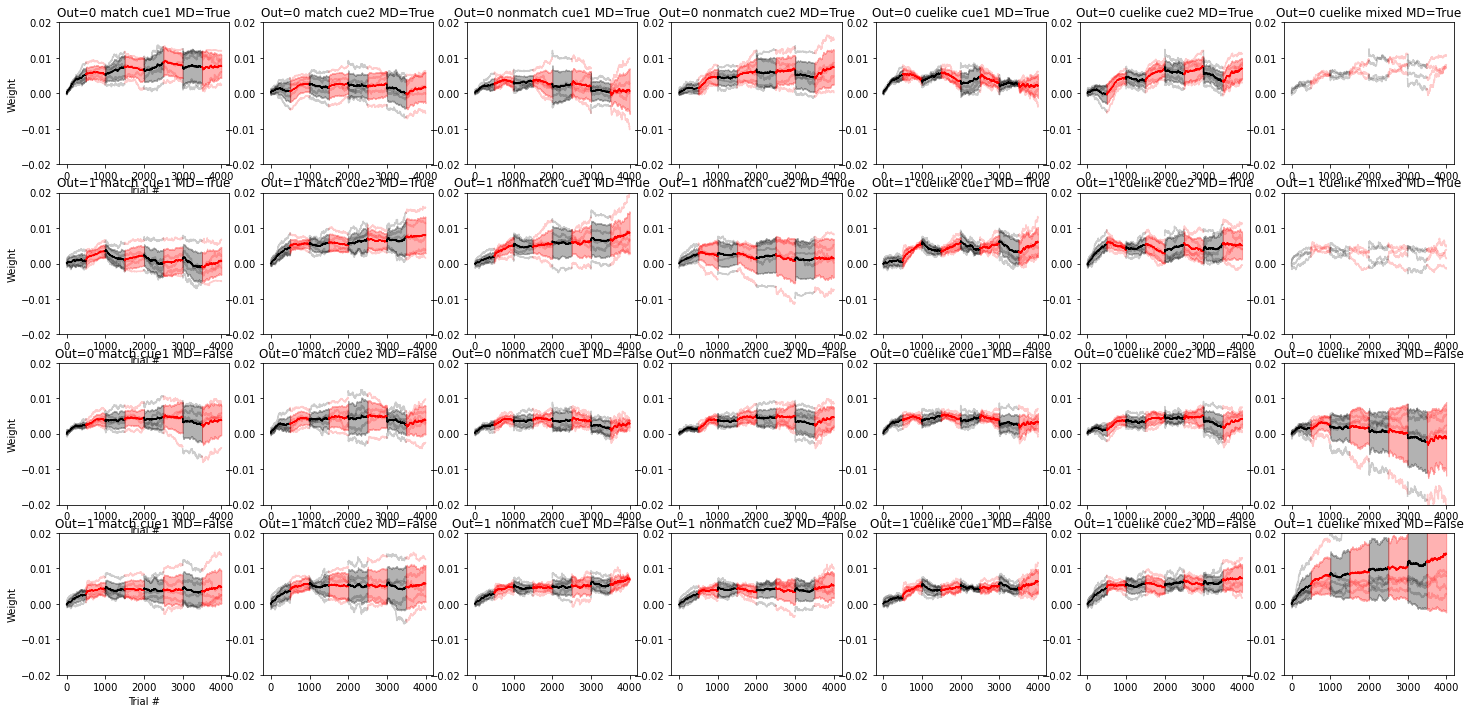

In [27]:
def plt_trials(ax, w, starts_with_match=True):
    if w.shape[1] == 0:
        return

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)
        c = 'k' if c == 'r' else 'r'

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        m = np.mean(w[s:t,:],1)
        e = np.std(w[s:t,:],1)        
        ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
        ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)
        c = 'k' if c == 'r' else 'r'

def plot_weights(scores_, scores_noMD_):
    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    ax1.set_ylim((-0.02,0.02))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    ax2.set_ylim((-0.02,0.02))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    ax3.set_ylim((-0.02,0.02))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    ax4.set_ylim((-0.02,0.02))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    ax5.set_ylim((-0.02,0.02))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    ax6.set_ylim((-0.02,0.02))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    ax7.set_ylim((-0.02,0.02))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    ax8.set_ylim((-0.02,0.02))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    ax9.set_ylim((-0.02,0.02))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    ax10.set_ylim((-0.02,0.02))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    ax11.set_ylim((-0.02,0.02))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    ax12.set_ylim((-0.02,0.02))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    ax13.set_ylim((-0.02,0.02))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    ax14.set_ylim((-0.02,0.02))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    ax15.set_ylim((-0.02,0.02))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    ax16.set_ylim((-0.02,0.02))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    ax17.set_ylim((-0.02,0.02))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    ax18.set_ylim((-0.02,0.02))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    ax19.set_ylim((-0.02,0.02))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    ax20.set_ylim((-0.02,0.02))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    ax21.set_ylim((-0.02,0.02))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    ax22.set_ylim((-0.02,0.02))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    ax23.set_ylim((-0.02,0.02))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    ax24.set_ylim((-0.02,0.02))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    ax25.set_ylim((-0.02,0.02))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    ax26.set_ylim((-0.02,0.02))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    ax27.set_ylim((-0.02,0.02))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    ax28.set_ylim((-0.02,0.02))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    N_TRIALS = 4000
    N_SIMS = 5
    wPFC_out0_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out0_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))
    
    for run_idx in range(0,5):
        i = run_idx #run_idx - 5
        s = run_idx * 500
        t = run_idx * 500 + 500
        scores = scores_[s:t]
        scores_noMD = scores_noMD_[s:t]
        (_, _, _, wPFC_output) = load_obj(RUNS_MD[run_idx])
        (_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[run_idx])
    
        cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
        cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
        cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
        cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
        cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
        cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

        x = np.arange(0,4000)
        wPFC_out0_all = wPFC_output[match_trials,0,:]
        wPFC_out1_all = wPFC_output[match_trials,1,:]
        wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
        wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

        m0 = np.mean(wPFC_out0_all,1)
        m1 = np.mean(wPFC_out1_all,1)
        e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
        e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

        m0_noMD = np.mean(wPFC_out0_all_noMD,1)
        m1_noMD = np.mean(wPFC_out1_all_noMD,1)
        e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
        e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

        wPFC_out0_match_cue1_MD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons[run_idx]],1)
        wPFC_out0_match_cue2_MD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out1_match_cue1_MD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons[run_idx]],1)
        wPFC_out1_match_cue2_MD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out0_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]],1)

        wPFC_out1_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]],1)


    plt_trials(ax1,wPFC_out0_match_cue1_MD)

    plt_trials(ax2,wPFC_out0_match_cue2_MD)

    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)

    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)

    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)

    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)

    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)

    plt_trials(ax8,wPFC_out1_match_cue1_MD)

    plt_trials(ax9,wPFC_out1_match_cue2_MD)

    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)

    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)

    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)

    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)

    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)

    plt_trials(ax15,wPFC_out0_match_cue1_noMD)

    plt_trials(ax16,wPFC_out0_match_cue2_noMD)

    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)

    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)

    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)

    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)

    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)

    plt_trials(ax22,wPFC_out1_match_cue1_noMD)

    plt_trials(ax23,wPFC_out1_match_cue2_noMD)

    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)

    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)

    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)

    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)

    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)

    plt.show()    

plot_weights(scores, scores_noMD)

# See if neurons are expected for cue category

## ... this can all be ignored now

[array([ 27,  29,  33,  62,  65,  67,  73,  74,  86,  87,  92, 100, 110,
       114, 116, 124, 127, 134, 135, 141, 145, 148, 149, 153, 154, 156,
       166, 171, 180, 209, 373, 425]), array([ 13,  29,  31,  40,  43,  47,  48,  54,  57,  59,  67,  69,  71,
        73,  81,  86,  90, 102, 114, 121, 136, 146, 152, 153, 156, 157,
       166, 168, 171, 180, 184, 185, 187, 196, 199, 250, 379, 387, 401,
       410, 414, 472, 485, 497]), array([ 22,  27,  54,  64,  70,  74,  78,  80,  98, 102, 124, 133, 134,
       136, 148, 161, 163, 184, 187, 193, 203, 209, 250, 340, 352, 373,
       387, 427, 489]), array([  1,   3,  13,  22,  23,  33,  35,  40,  48,  54,  60,  78,  80,
        86,  96, 100, 112, 114, 134, 135, 149, 153, 154, 156, 161, 163,
       168, 190, 193, 194, 209, 223, 227, 340, 342, 467, 494]), array([ 11,  33,  73,  74, 129, 141, 153, 154, 174, 179, 185, 342, 352,
       379]), array([  3,  11,  12,  22,  27,  29,  45,  64,  66,  71,  73,  74,  96,
        99, 110, 133, 135, 136, 

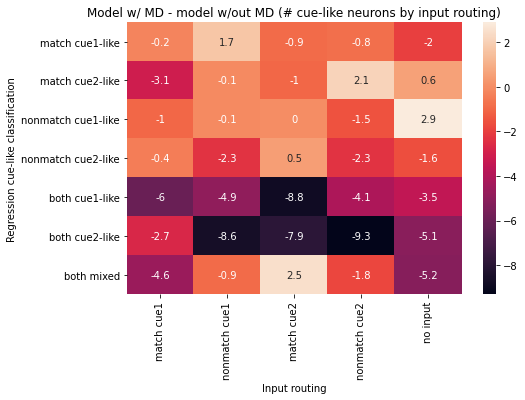

In [52]:
def count_groups(X):
    Y = []
    for arr in X:
        d = [0, 0, 0, 0, 0]
        for neuron_idx in arr:
            if neuron_idx < 100:
                d[0] = d[0] + 1
            elif neuron_idx < 200:
                d[1] = d[1] + 1
            elif neuron_idx < 300:
                d[2] = d[2] + 1
            elif neuron_idx < 400:
                d[3] = d[3] + 1
            elif neuron_idx < 500:
                d[4] = d[4] + 1
        Y.append(d)
    return Y

def comp_diff(a,b):
    A = np.matrix(count_groups(a))
    B = np.matrix(count_groups(b))
    return np.subtract(A,B).tolist()
    
D = {}
D["match cue1"] = comp_diff(match_cue1_neurons, match_cue1_neurons_noMD)
D["match cue2"] = comp_diff(match_cue2_neurons, match_cue2_neurons_noMD)
D["nonmatch cue1"] = comp_diff(nonmatch_cue1_neurons, nonmatch_cue1_neurons_noMD)
D["nonmatch cue2"] = comp_diff(nonmatch_cue2_neurons, nonmatch_cue2_neurons_noMD)
D["both cue1"] = comp_diff(cuelike_cue1_neurons, cuelike_cue1_neurons_noMD)
D["both cue2"] = comp_diff(cuelike_cue2_neurons, cuelike_cue2_neurons_noMD)
D["both mixed"] = comp_diff(cuelike_mixed_neurons, cuelike_mixed_neurons_noMD)

Ms = []
for i in range(len(D["match cue1"])):
    M = [D["match cue1"][i], 
         D["match cue2"][i],
         D["nonmatch cue1"][i],
         D["nonmatch cue2"][i],
         D["both cue1"][i],
         D["both cue2"][i],
         D["both mixed"][i]]
    Ms.append(M)

F = np.zeros((len(Ms[0]), len(Ms[0][0])))
    
for r in range(len(Ms[0])):
    for c in range(len(Ms[0][0])):
        s = 0
        for idx in range(len(D["match cue1"])):
            s = s + Ms[idx][r][c]
        F[r,c] = s / len(D["match cue1"])
        
        
cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'nonmatch cue1', 'match cue2', 'nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("Model w/ MD - model w/out MD (# cue-like neurons by input routing)")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

<AxesSubplot:title={'center':'Grouped Bar Graph with dataframe'}, xlabel='Cue-like'>

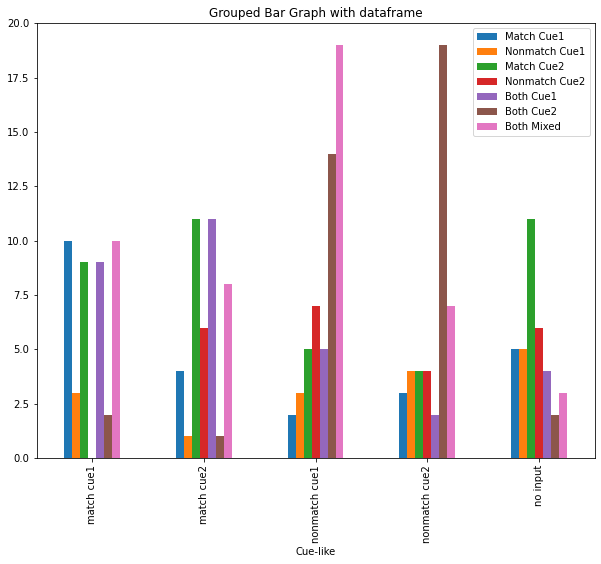

In [24]:
import pandas as pd
from operator import add

def get_plot_group(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_group_noMD(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group(neuron_idx)
        D = list(map(add, D, group))
    return D

def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group_noMD(neuron_idx)
        D = list(map(add, D, group))
    return D
  
    
D_0_100 = ["match cue1"] + get_plot_data(0,100)
D_100_200 = ["match cue2"] + get_plot_data(100,200)
D_200_300 = ["nonmatch cue1"] + get_plot_data(200,300)
D_300_400 = ["nonmatch cue2"] + get_plot_data(300,400)
D_400_500 = ["no input"] + get_plot_data(400,500)

# D_0_100 = ["match cue1"] + get_plot_data_noMD(0,100)
# D_100_200 = ["match cue2"] + get_plot_data_noMD(100,200)
# D_200_300 = ["nonmatch cue1"] + get_plot_data_noMD(200,300)
# D_300_400 = ["nonmatch cue2"] + get_plot_data_noMD(300,400)
# D_400_500 = ["no input"] + get_plot_data_noMD(400,500)

df = pd.DataFrame([D_0_100, D_100_200, D_200_300, D_300_400, D_400_500],
                  columns=['Cue-like', 'Match Cue1', 'Nonmatch Cue1', 'Match Cue2', 'Nonmatch Cue2', 'Both Cue1', 'Both Cue2', 'Both Mixed'])
df.plot(figsize=(10,8),
        x='Cue-like',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe',
        ylim=(0,20))


In [27]:
# Produce difference matrix plot (take mean over each initalization)

1